In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from matplotlib.colors import ListedColormap
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as mtick
from bokeh.palettes import viridis
import statsmodels.api as sm
from sklearn import datasets

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

In [4]:
%%html
<style>
/* Any CSS style can go in here. */
.dataframe th {
    font-size: 14px;
}
.dataframe td {
    font-size: 13px;
}
</style>

In [5]:
df_olymp = pd.read_csv('athlete_events.csv', index_col='ID')
df_regions = pd.read_csv('noc_regions.csv', index_col='NOC')

In [6]:
df_regions[~df_regions['notes'].isnull()].head()

,region,notes
NOC,,
AHO,Curacao,Netherlands Antilles
ANT,Antigua,Antigua and Barbuda
ANZ,Australia,Australasia
BOH,Czech Republic,Bohemia
CRT,Greece,Crete


### Region Dictionary to Dataframe

In [7]:
Africa = {"Eastern Africa": ["Burundi", "Comoros", "Djibouti", "Eritrea", "Ethiopia", "Kenya","Madagascar", "Malawi",
                             "Mauritius", "Mayotte", "Mozambique", "Reunion", "Rwanda", "Seychelles", "Somalia", "South Sudan",
                             "Uganda", "Tanzania", "Zambia", "Zimbabwe"],
          "Middle Africa": ["Angola", "Cameroon", "Central African Republic", "Chad", "Republic of Congo",
                            "Democratic Republic of the Congo", "Equatorial Guinea", "Gabon", "Sao Tome and Principe"],
          "Northern Africa": ["Algeria", "Egypt", "Libya", "Morocco", "Sudan", "Tunisia", "Western Sahara"],
          "Southern Africa": ["Botswana", "Lesotho", "Namibia", "South Africa", "Swaziland"],
          "Western Africa": ["Benin", "Burkina Faso", "Cabo Verde", "Cape Verde", "Cote d'Ivoire", "Ivory Coast", "Gambia",
                             "Ghana", "Guinea", "Guinea-Bissau", "Liberia", "Mali", "Mauritania", "Niger", "Nigeria",
                             "Saint Helena", "Senegal", "Sierra Leone", "Togo"]}

Americas = {"Caribbean": ["Anguilla", "Antigua", "Barbuda", "Aruba", "Bahamas", "Barbados", "Bonaire", "Saint Eustatius and Saba",
                          "Virgin Islands, British", "Cayman Islands", "Cuba", "Curacao", "Dominica", "Dominican Republic",
                          "Grenada", "Guadeloupe", "Haiti", "Jamaica", "Martinique", "Montserrat", "-Netherlands Antilles",
                          "Puerto Rico", "Saint Barthelemy", "Saint Kitts", "Nevis", "Saint Lucia", "Saint Martin", "Saint Vincent",
                          "The Grenadines", "Trinidad", "Tobago", "Turks and Caicos Islands", "Virgin Islands, US"],
            "Central America": ["Belize", "Costa Rica", "El Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua", "Panama"],
            "South America": ["Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador", "Falkland Islands", "Malvinas",
                              "French Guiana", "Guyana", "Paraguay", "Peru", "Suriname", "Uruguay", "Venezuela"],
            "North America": ["Bermuda", "Canada", "Greenland", "Saint Pierre and Miquelon", "United States of America", "USA"]}

Asia = {"Central Asia": ["Kazakhstan", "Kyrgyzstan", "Tajikistan", "Turkmenistan", "Uzbekistan"],
        "East Asia": ["China", "Hong Kong Special Administrative Region of China", "Macao Special Administrative Region of China",
                      "Democratic People's Republic of Korea", "North Korea", "Japan", "Mongolia", "Republic of Korea",
                      "South Korea", "Taiwan"],
        "South Central Asia": ["Afghanistan", "Bangladesh", "Bhutan", "India", "Iran", "Maldives", "Nepal", "Pakistan", "Sri Lanka"],
        "South East Asia": ["Brunei", "Cambodia", "Indonesia", "Laos", "Malaysia", "Myanmar", "Burma", "Philippines", "Singapore",
                            "Thailand", "Timor-Leste", "East Timor", "Vietnam"],
        "Middle East": ["Armenia", "Azerbaijan", "Bahrain", "Cyprus", "Georgia", "Iraq", "Israel", "Jordan", "Kuwait", "Lebanon",
                        "Oman", "Palestine", "Qatar", "Saudi Arabia", "Syria", "Turkey", "United Arab Emirates", "Yemen"]}

Europe = {"Eastern Europe": ["Belarus", "Bulgaria", "Czech Republic", "Hungary", "Poland", "Moldova", "Romania", "Russia", "Slovakia",
                             "Ukraine"],
          "Northern Europe": ["Denmark", "Estonia", "Faroe Islands", "Finland", "Aland Islands", "Iceland", "Ireland", "Latvia",
                              "Lithuania", "Norway", "Svalbard and Jan Mayen Islands", "Sweden", "UK", "England", "Scotland", "Wales",
                              "Northern Ireland", "Isle of Man", "Channel Islands", "Guernsey", "Jersey", "Sark"],
          "Southern Europe": ["Albania", "Andorra", "Bosnia and Herzegovina", "Croatia", "Gibraltar", "Greece", "Holy See", "Italy",
                              "Macedonia", "Malta", "Montenegro", "Kosovo", "Portugal", "San Marino", "Serbia", "Slovenia", "Spain"],
          "Western Europe": ["Austria", "Belgium", "France", "Germany", "Liechtenstein", "Luxembourg", "Monaco", "Netherlands",
                             "Holland", "Switzerland"]}

Oceania = {"Australia and New Zealand": ["Australia", "New Zealand", "Norfolk Island"],
           "Melanesia": ["Fiji", "New Caledonia", "Papua New Guinea", "Solomon Islands", "Vanuatu"],
           "Micronesia": ["Guam", "Kiribati", "Marshall Islands", "Micronesia", "Nauru", "Northern Mariana Islands", "Palau"],
           "Polynesia": ["American Samoa", "Cook Islands", "French Polynesia", "Niue", "Pitcairn", "Samoa", "Tokelau", "Tonga",
                         "Tuvalu", "Wallis and Futuna Islands"]}

Null = {"Null": ["Individual Olympic Athletes", "Refugee Olympic Athletes", "Unknown"]}

continents = [Africa, Americas, Asia, Europe, Oceania, Null]
continents_lst = ["Africa", "Americas", "Asia", "Europe", "Oceania", "Null"]

df_country = pd.DataFrame(columns=['Country', 'Region', 'Continent'])
df_country.set_index('Country', inplace=True)

for cnt_index, cont_name in enumerate(continents):
    for region, countries_lst in cont_name.items():
        for cntry in countries_lst:
            df_country.loc[cntry] = [region, continents_lst[cnt_index]]

### Fill in missing values

In [8]:
# insert missing entry for a few countries into df_regions
df_regions.loc['SGP'] = ['Singapore', np.nan]
df_regions.loc['TUV'] = ['Tuvalu', np.nan]
df_regions.loc['ROT'] = ['Refugee Olympic Athletes', np.nan]
df_regions.loc['UNK'] = ['Unknown', np.nan]
df_regions.loc['BOL'] = ['Bolivia', np.nan]

### Add Columns matching values from other dataframes

In [9]:
# create a column that matches the country code from df_olymp to the country name in df_regions
df_olymp['Country'] = df_olymp['NOC'].apply(lambda x: df_regions.loc[x, 'region'])

In [10]:
df_olymp['Area'] = df_olymp['Country'].apply(lambda x: df_country.loc[x, 'Region'])
df_olymp['Continent'] = df_olymp['Country'].apply(lambda x: df_country.loc[x, 'Continent'])

### Edit & Add Columns

In [11]:
# set the null values to 0 so we can change the datatype in column age
df_olymp['Age'] = df_olymp['Age'].fillna(0)
df_olymp['Age'] = df_olymp['Age'].astype('int64')

# insert formula for bmi
df_olymp['BMI'] = df_olymp['Weight']/((df_olymp['Height']/100)**2)

# change weight to lbs 
df_olymp['Weight'] = df_olymp['Weight'].fillna(0)
df_olymp['Weight'] = (df_olymp['Weight'] * 2.204).round(1)

# revert zero values to null values so they're not included in mean calculations later
df_olymp.loc[df_olymp['Weight']==0.0, 'Weight'] = np.nan
df_olymp['Year'] = df_olymp['Year'].astype('int')

# create column for the gender of the event (setting unspecified events to A)
df_olymp['Event_gender'] = 'A'
womens = df_olymp['Event'].str.contains('Women')
df_olymp.loc[womens, 'Event_gender'] = 'F'
mens = df_olymp['Event'].str.contains('Men')
df_olymp.loc[mens, 'Event_gender'] = 'M'

# creating a key for each medal so that it isn't counted more than once
# when a team wins that medal
df_olymp['Medal_key'] = df_olymp['Medal'] + df_olymp['Games'] + df_olymp['Event'] + df_olymp['Team']

'Team' is often just the country name, but multiple teams from the same country can compete in the same event (like archery teams, or tennis doubles).
In those cases this distinction is indicated by adding a number to the end of the country name or naming the team outright.

I'm making the assumption is that if multiple individuals win the gold medal in the same event, at the same games,
and on the same 'team', it's a team played event (and they are only one entity
in terms of the competition).
Occasionally 2 people will win the gold medal in the same event/same team (like in gymnastics, for instance)
but were competing individually. 
I subtract the number of years that multiple individuals w/ a gold medal from same event, games, and team occured
in that event from the total number of years the event has been held to remove 1 off exceptions like above.

In [12]:
df_olymp['Ind_or_team'] = 'individual'

# This counts the number of individuals that had the same medal/event/games/team
# 'Year' is technically redundant but is included in the groupby bc sometimes 2 teams will both win the gold medal
# in that event the same year and we want the multiple_players groupby to be able to count the number of unique years that occured
grp_medals = df_olymp.loc[(df_olymp['Medal']=='Gold')].groupby(['Event', 'Medal_key', 'Year'])[['Name']].nunique().reset_index()
multiple_players = grp_medals[grp_medals['Name']>1].groupby('Event')[['Year']].nunique().rename(columns={'Year': 'Years_multiple_players'})
event_held = df_olymp.groupby('Event')[['Year']].nunique().rename(columns={'Year': 'Total_years'})
grp_years = pd.merge(multiple_players, event_held, on='Event')
grp_years = grp_years.loc[~(grp_years['Total_years']-grp_years['Years_multiple_players']>1)]

team_sports = list(grp_years.index)
df_olymp.loc[df_olymp['Event'].isin(team_sports), ['Ind_or_team']] = 'team'

# # creating a 'competitor key' to discern every competition entity
# # so that if someone is competing as an individual in an event, they have their own
# # competitor key (for that event), if a team is playing, each of those players has the same 'competitor_key'
df_olymp['temp_name'] = df_olymp['Name']
df_olymp.loc[df_olymp['Ind_or_team']=='team', 'temp_name'] = ''
df_olymp['Competitor_key'] = df_olymp['Country'] + df_olymp['Games'] + df_olymp['Event'] + df_olymp['Team'] + df_olymp['temp_name']
df_olymp.drop(columns=['temp_name'], inplace=True)

***

# New Experiments

In [13]:
# Gold medals per competitor by country
grp_country = df_olymp.loc[df_olymp['Year']==2008].groupby(['Area', 'Country'])[['Event','Competitor_key', 'Name', 'Medal_key']].nunique()
grp_country['Wins_per_competitor'] = grp_country['Medal_key']/grp_country['Competitor_key']
grp_country

Event  \
Area                      Country                                   
Australia and New Zealand Australia                           219   
                          New Zealand                          78   
Caribbean                 Antigua                               5   
                          Aruba                                 2   
                          Bahamas                              22   
                          Barbados                             10   
                          Cayman Islands                        6   
                          Cuba                                102   
                          Curacao                               4   
                          Dominica                              2   
                          Dominican Republic                   21   
                          Grenada                               8   
                          Haiti                                 7   
                          Jamaica                              29   
                          Puerto Rico                          31   
                          Saint Kitts                           5   
                          Saint Lucia                           4   
                          Saint Vincent                         2   
                          Trinidad                             19   
                          Virgin Islands, British               2   
                          Virgin Islands, US                    8   
Central America           Belize                                4   
                          Costa Rica                            8   
                          El Salvador                          14   
                          Guatemala                            12   
                          Honduras                              8   
                          Mexico                               73   
                          Nicaragua                             7   
                          Panama                                5   
Central Asia              Kazakhstan                          106   
                          Kyrgyzstan                           22   
                          Tajikistan                           16   
                          Turkmenistan                          9   
                          Uzbekistan                           67   
East Asia                 China                               259   
                          Japan                               176   
                          Mongolia                             29   
                          North Korea                          38   
                          South Korea                         142   
                          Taiwan                               41   
Eastern Africa            Burundi                               3   
                          Comoros                               3   
                          Djibouti                              2   
                          Eritrea                               6   
                          Ethiopia                             10   
                          Kenya                                24   
                          Madagascar                            6   
                          Malawi                                4   
                          Mauritius                            11   
                          Mozambique                            4   
                          Rwanda                                4   
                          Seychelles                            9   
                          Somalia                               2   
                          Tanzania                              6   
                          Uganda                               10   
                          Zambia                                8   
                          Zimbabwe                        

In [14]:
# most gold medals won by a single person
df_summer = df_olymp[(df_olymp['Games'].str.contains('Summer'))&(df_olymp['Year']>=1948)]
grp_people = df_summer[df_summer['Medal']=='Gold'].groupby(['Name', 'Sport'])[['Medal_key']].nunique()
grp_people.sort_values('Medal_key', ascending=False).head(20)

,,Medal_key
Name,Sport,
"Michael Fred Phelps, II",Swimming,23
Mark Andrew Spitz,Swimming,9
"Frederick Carlton ""Carl"" Lewis",Athletics,9
Larysa Semenivna Latynina (Diriy-),Gymnastics,9
"Jennifer Elisabeth ""Jenny"" Thompson (-Cumpelik)",Swimming,8
"Matthew Nicholas ""Matt"" Biondi",Swimming,8
Sawao Kato,Gymnastics,8
Birgit Fischer-Schmidt,Canoeing,8
Usain St. Leo Bolt,Athletics,8


In [15]:
df_summer_2008 = df_olymp.loc[(df_olymp['Games'].str.contains('Summer'))&(df_olymp['Year']==2008)]
# number of events that someone from that region received a medal in:
pv_won_events_2008 = df_summer_2008.loc[~(df_summer_2008['Medal'].isnull())].pivot_table(index='Area', columns='Sport', values='Event', aggfunc='nunique', fill_value=0)
# number of events in that sport in which someone from that region competed:
pv_events_2008 = df_summer_2008.pivot_table(index='Area', columns='Sport', values='Event', aggfunc='nunique')

In [16]:
# the proportion of participated events that someone medaled
pv_won_events_2008.div(pv_events_2008)

Sport,Archery,Athletics,Badminton,Baseball,Basketball,Beach Volleyball,Boxing,Canoeing,Cycling,Diving,Equestrianism,Fencing,Football,Gymnastics,Handball,Hockey,Judo,Modern Pentathlon,Rhythmic Gymnastics,Rowing,Sailing,Shooting,Softball,Swimming,Synchronized Swimming,Table Tennis,Taekwondo,Tennis,Trampolining,Triathlon,Volleyball,Water Polo,Weightlifting,Wrestling
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Australia and New Zealand,0.000000,0.214286,0.0,NaN,0.5,0.0,0.000000,0.357143,0.166667,0.250000,0.166667,0.000000,0.0,0.000000,NaN,0.5,0.000000,0.0,0.0,0.357143,0.363636,0.066667,1.0,0.558824,0.0,0.00,0.000000,0.00,0.0,1.0,NaN,0.5,0.000000,0.000000
Caribbean,0.000000,0.428571,NaN,1.0,NaN,0.0,0.727273,0.000000,0.250000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.428571,0.0,NaN,0.000000,0.000000,0.111111,NaN,0.000000,NaN,0.00,0.333333,0.00,NaN,NaN,0.0,NaN,0.000000,0.083333
Central America,0.000000,0.047619,0.0,NaN,NaN,0.0,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.0,0.000000,NaN,NaN,0.000000,0.0,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.0,0.00,0.400000,0.00,NaN,0.0,NaN,NaN,0.000000,0.000000
Central Asia,0.000000,0.000000,NaN,NaN,NaN,NaN,0.200000,0.000000,0.000000,NaN,NaN,0.000000,NaN,0.100000,0.0,NaN,0.307692,0.0,0.0,0.000000,NaN,0.000000,NaN,0.000000,0.0,0.00,0.250000,0.00,1.0,0.0,0.0,NaN,0.444444,0.444444
East Asia,1.000000,0.071429,1.0,1.0,0.0,0.5,0.454545,0.066667,0.142857,1.000000,0.000000,0.400000,0.0,0.857143,0.5,0.5,0.928571,0.0,0.5,0.200000,0.181818,0.533333,1.0,0.333333,1.0,1.00,0.875000,0.25,1.0,0.0,0.5,0.0,0.923077,0.470588
Eastern Africa,0.000000,0.545455,0.0,NaN,NaN,NaN,0.125000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,0.363636,NaN,NaN,0.000000,0.00,NaN,0.0,NaN,NaN,0.000000,NaN
Eastern Europe,0.250000,0.500000,0.0,NaN,0.5,0.0,0.545455,0.750000,0.222222,0.714286,0.000000,0.500000,NaN,0.357143,0.5,NaN,0.142857,1.0,1.0,0.461538,0.000000,0.600000,NaN,0.205882,1.0,0.00,NaN,0.25,0.0,0.0,0.5,0.5,0.600000,0.944444
Melanesia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Micronesia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# number of US competitors (teams count as 1) in various sports over time
df_summer = df_olymp[(df_olymp['Games'].str.contains('Summer'))&(df_olymp['Year']>=1948)]
us_competitors = df_summer.loc[df_summer['Country'] == 'USA'].pivot_table(index='Year', columns='Sport', values='Competitor_key', aggfunc='nunique', fill_value=0)
years = list(us_competitors.index)
# us_competitors
# us_competitors = us_competitors.apply(lambda x: x/x.sum(), axis=1)
# the difference from the proportions of all participants
# us_competitors.sub(all_competitors)

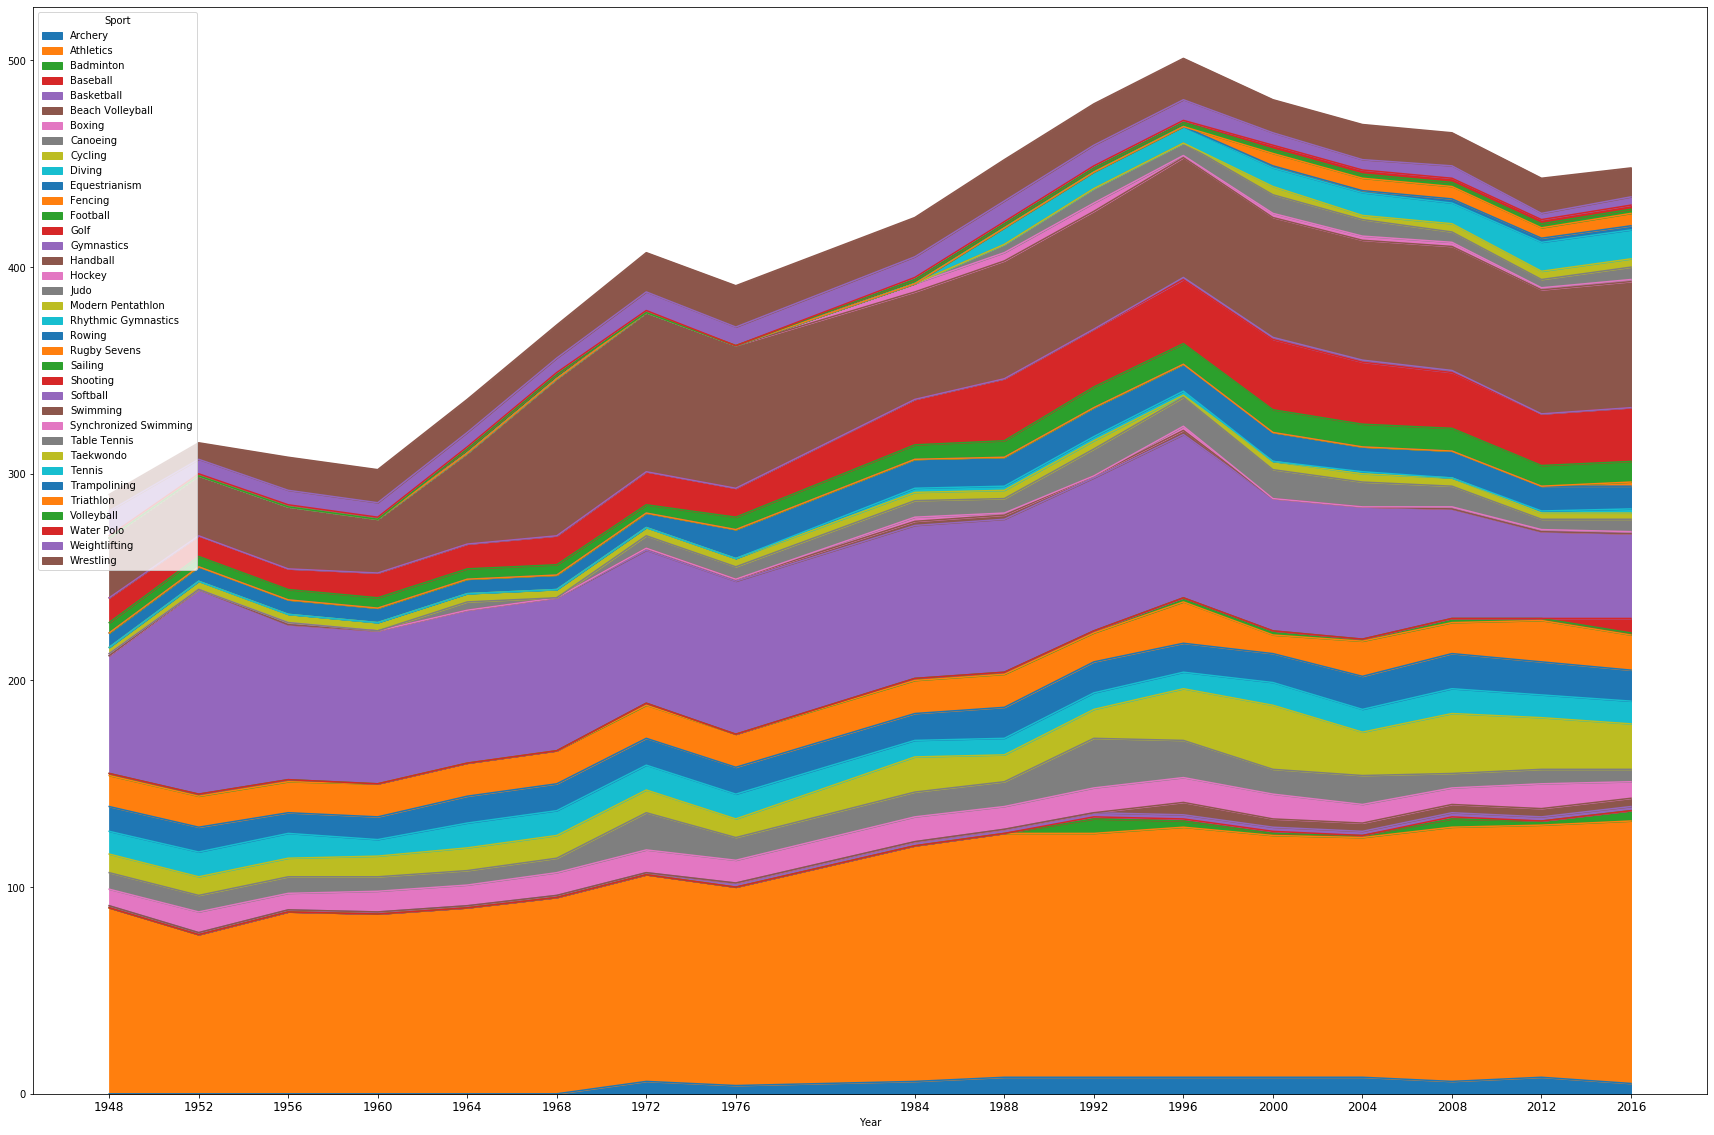

In [18]:
# plt.figure(figsize=(30,30))
us_competitors.plot.area(figsize=(30,20))
plt.xticks(years, fontsize=12)
plt.show()

In [19]:
# Total number of competitors (teams count as 1) in specific sports over time 
all_competitors = df_summer.pivot_table(index='Year', columns='Sport', values='Competitor_key', aggfunc='nunique', fill_value=0)

In [20]:
rainbow = ['#a80000', '#db4d00', '#f0a315', '#fff108', '#6caf00', '#00755c', '#00a3af', '#0052af', '#3700af', '#8000af',  '#ff0c0c', '#ff7931', '#f4be58', '#fff651', '#a3ff10', '#00e7b5', '#10efff', '#1080ff', '#5c10ff', '#bf10ff']

The olympics were held in Australia in 1956 (the first time they were held outside of Europe), which led to a decline in attendance from South American and European athletes***FACT CHECK

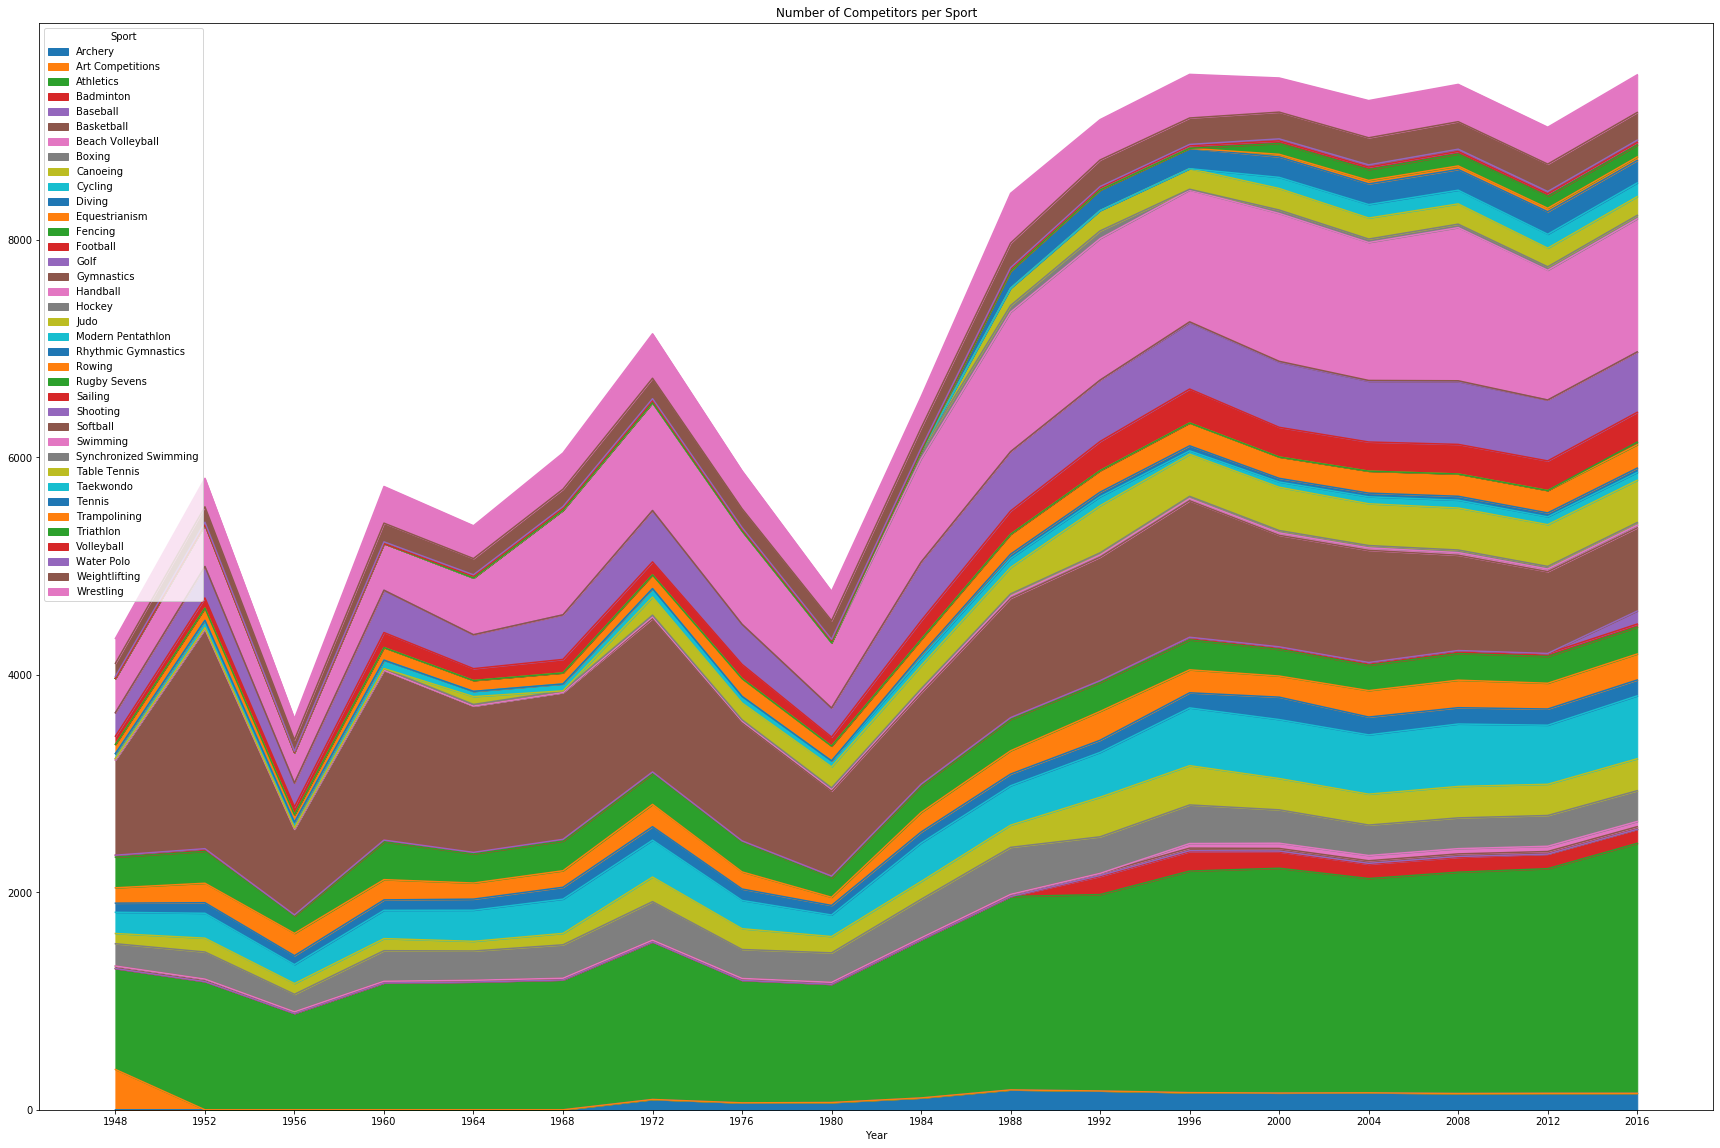

In [21]:
all_competitors.plot.area(figsize=(30,20))
plt.title('Number of Competitors per Sport')
plt.xticks(list(all_competitors.index))
plt.show()

In [297]:
# pv_countries = df_summer.pivot_table(index='Year', columns='Area', values='Competitor_key', aggfunc='nunique')

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,Area,Continent,BMI,Event_gender,Medal_key,Ind_or_team,Competitor_key
ID,,,,,,,,,,,,,,,,,,,,,,
2277,Darija Alauf,F,23,NaN,NaN,Individual Olympic Athletes,IOA,1992 Summer,1992,Summer,Barcelona,Swimming,Swimming Women's 100 metres Backstroke,NaN,Individual Olympic Athletes,Null,Null,NaN,F,NaN,individual,Individual Olympic Athletes1992 SummerSwimming...
2277,Darija Alauf,F,23,NaN,NaN,Individual Olympic Athletes,IOA,1992 Summer,1992,Summer,Barcelona,Swimming,Swimming Women's 200 metres Backstroke,NaN,Individual Olympic Athletes,Null,Null,NaN,F,NaN,individual,Individual Olympic Athletes1992 SummerSwimming...
7534,Vladimir Banjanac,M,25,187.0,182.9,Individual Olympic Athletes,IOA,1992 Summer,1992,Summer,Barcelona,Rowing,Rowing Men's Coxless Pairs,NaN,Individual Olympic Athletes,Null,Null,23.735308,M,NaN,team,Individual Olympic Athletes1992 SummerRowing M...
11592,Aranka Binder,F,26,163.0,103.6,Individual Olympic Athletes,IOA,1992 Summer,1992,Summer,Barcelona,Shooting,"Shooting Women's Air Rifle, 10 metres",Bronze,Individual Olympic Athletes,Null,Null,17.689789,F,"Bronze1992 SummerShooting Women's Air Rifle, 1...",individual,Individual Olympic Athletes1992 SummerShooting...
14684,Slobodan Brankovi,M,24,190.0,180.7,Individual Olympic Athletes,IOA,1992 Summer,1992,Summer,Barcelona,Athletics,Athletics Men's 400 metres,NaN,Individual Olympic Athletes,Null,Null,22.714681,M,NaN,individual,Individual Olympic Athletes1992 SummerAthletic...
15205,Mio Brkovi,M,24,186.0,176.3,Individual Olympic Athletes,IOA,1992 Summer,1992,Summer,Barcelona,Cycling,Cycling Men's 100 kilometres Team Time Trial,NaN,Individual Olympic Athletes,Null,Null,23.124061,M,NaN,team,Individual Olympic Athletes1992 SummerCycling ...
21666,Suzana iri,F,23,164.0,103.6,Individual Olympic Athletes,IOA,1992 Summer,1992,Summer,Barcelona,Athletics,"Athletics Women's 10,000 metres",NaN,Individual Olympic Athletes,Null,Null,17.474717,F,NaN,individual,Individual Olympic Athletes1992 SummerAthletic...
24163,Radia ubri,M,30,NaN,NaN,Individual Olympic Athletes,IOA,1992 Summer,1992,Summer,Barcelona,Cycling,"Cycling Men's Road Race, Individual",NaN,Individual Olympic Athletes,Null,Null,NaN,M,NaN,individual,Individual Olympic Athletes1992 SummerCycling ...
29840,Milan orevi,M,23,176.0,143.3,Individual Olympic Athletes,IOA,1992 Summer,1992,Summer,Barcelona,Canoeing,"Canoeing Men's Kayak Singles, Slalom",NaN,Individual Olympic Athletes,Null,Null,20.983988,M,NaN,individual,Individual Olympic Athletes1992 SummerCanoeing...


In [306]:
# Number of competitors from each country per year of the summer olympics
cntry_competitors = df_summer.pivot_table(index='Year', columns='Country', values='Competitor_key', aggfunc='nunique', fill_value=0)

In [299]:
# Total number of Events in specific sports over time 
all_events = df_summer.pivot_table(index='Year', columns='Sport', values='Event', aggfunc='nunique', fill_value=0)

Sport,Archery,Art Competitions,Athletics,Badminton,Baseball,Basketball,Beach Volleyball,Boxing,Canoeing,Cycling,Diving,Equestrianism,Fencing,Football,Golf,Gymnastics,Handball,Hockey,Judo,Modern Pentathlon,Rhythmic Gymnastics,Rowing,Rugby Sevens,Sailing,Shooting,Softball,Swimming,Synchronized Swimming,Table Tennis,Taekwondo,Tennis,Trampolining,Triathlon,Volleyball,Water Polo,Weightlifting,Wrestling
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,NaN,-1.0,0.000000,NaN,NaN,0.0,NaN,0.250000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,NaN,0.666667,NaN,0.0,NaN,1.0,NaN,0.0,NaN,0.250000,0.750000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.166667,0.000
1956,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.000000,0.000000,NaN,0.181818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000
1960,NaN,NaN,0.030303,NaN,NaN,0.0,NaN,0.000000,-0.222222,0.000000,0.0,-0.166667,0.142857,0.0,NaN,-0.066667,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.000000,-0.142857,NaN,0.153846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000
1964,NaN,NaN,0.058824,NaN,NaN,0.0,NaN,0.000000,0.000000,0.166667,0.0,0.200000,0.000000,0.0,NaN,0.000000,NaN,0.0,inf,0.0,NaN,0.0,NaN,0.000000,0.000000,NaN,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,inf,0.0,0.000000,0.000
1968,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,0.100000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,NaN,0.000000,NaN,0.0,-1.000000,0.0,NaN,0.0,NaN,0.000000,0.166667,NaN,0.611111,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,0.000
1972,inf,NaN,0.055556,NaN,NaN,0.0,NaN,0.000000,0.571429,0.000000,0.0,0.000000,0.000000,0.0,NaN,0.000000,inf,0.0,inf,0.0,NaN,0.0,NaN,-0.200000,0.142857,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.285714,0.250
1976,0.0,NaN,-0.026316,NaN,NaN,1.0,NaN,0.000000,0.000000,-0.142857,0.0,0.000000,0.000000,0.0,NaN,0.000000,1.0,0.0,0.000000,0.0,NaN,1.0,NaN,0.500000,-0.125000,NaN,-0.103448,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,0.000
1980,0.0,NaN,0.027027,NaN,NaN,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,NaN,0.000000,0.0,1.0,0.333333,0.0,NaN,0.0,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.111111,0.000


In [307]:
# average number of competitors per event
all_competitors.div(all_events)

Sport,Archery,Art Competitions,Athletics,Badminton,Baseball,Basketball,Beach Volleyball,Boxing,Canoeing,Cycling,Diving,Equestrianism,Fencing,Football,Golf,Gymnastics,Handball,Hockey,Judo,Modern Pentathlon,Rhythmic Gymnastics,Rowing,Rugby Sevens,Sailing,Shooting,Softball,Swimming,Synchronized Swimming,Table Tennis,Taekwondo,Tennis,Trampolining,Triathlon,Volleyball,Water Polo,Weightlifting,Wrestling
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1948,NaN,20.611111,28.121212,NaN,NaN,23.0,NaN,25.625000,10.444444,32.500000,21.000,23.500000,40.285714,18.0,NaN,97.333333,NaN,13.0,NaN,45.0,NaN,12.142857,NaN,18.750000,54.000000,NaN,28.727273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,20.000000,14.312500
1952,NaN,NaN,35.727273,NaN,NaN,23.0,NaN,24.900000,14.111111,38.166667,24.250,29.833333,41.857143,25.0,NaN,134.666667,NaN,12.0,NaN,33.5,NaN,16.142857,NaN,18.600000,41.285714,NaN,35.090909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,20.285714,16.375000
1956,NaN,NaN,26.848485,NaN,NaN,15.0,NaN,16.100000,11.000000,29.000000,20.500,34.166667,22.714286,11.0,NaN,52.533333,NaN,12.0,NaN,26.0,NaN,9.857143,NaN,14.400000,31.285714,NaN,21.692308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,15.000000,12.187500
1960,NaN,NaN,34.294118,NaN,NaN,16.0,NaN,28.100000,15.857143,43.333333,24.000,37.200000,43.500000,16.0,NaN,111.500000,NaN,16.0,NaN,38.5,NaN,16.571429,NaN,27.600000,64.833333,NaN,28.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,24.571429,21.062500
1964,NaN,NaN,32.638889,NaN,NaN,16.0,NaN,26.900000,12.714286,40.857143,25.500,24.666667,33.500000,14.0,NaN,96.071429,NaN,15.0,18.000000,24.0,NaN,14.285714,NaN,21.800000,52.000000,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,8.0,13.0,21.285714,18.875000
1968,NaN,NaN,33.166667,NaN,NaN,16.0,NaN,27.909091,15.000000,45.000000,27.250,25.333333,34.125000,16.0,NaN,96.357143,NaN,16.0,NaN,31.5,NaN,14.571429,NaN,24.800000,58.571429,NaN,33.172414,NaN,NaN,NaN,NaN,NaN,NaN,9.0,15.0,22.857143,20.812500
1972,47.50,NaN,38.131579,NaN,NaN,16.0,NaN,32.181818,20.545455,48.428571,31.000,34.166667,35.375000,16.0,NaN,100.642857,16.0,16.0,27.666667,39.0,NaN,18.000000,NaN,30.000000,59.000000,NaN,34.206897,NaN,NaN,NaN,NaN,NaN,NaN,10.0,16.0,20.888889,20.450000
1976,32.00,NaN,30.432432,NaN,NaN,9.0,NaN,24.181818,17.363636,43.333333,26.250,26.166667,34.125000,13.0,NaN,77.428571,9.0,11.0,25.666667,30.5,NaN,11.714286,NaN,21.666667,52.714286,NaN,33.038462,NaN,NaN,NaN,NaN,NaN,NaN,9.0,12.0,19.222222,17.450000
1980,33.50,NaN,28.605263,NaN,NaN,9.0,NaN,24.636364,13.636364,33.000000,22.000,12.500000,22.375000,16.0,NaN,55.785714,9.0,6.0,24.125000,27.5,NaN,9.714286,NaN,13.833333,38.142857,NaN,23.115385,NaN,NaN,NaN,NaN,NaN,NaN,9.0,12.0,17.200000,13.500000


In [186]:
df_trial = df_summer.loc[(df_summer['Sport']=='Gymnastics')&(df_summer['Medal'].notnull())&(df_summer['Year']==2000)]
pv_medals = df_summer.pivot_table(index='Country', columns='Medal', values='Medal_key', aggfunc='nunique', margins=True)
pv_medals.sort_values(by='Gold')

Medal,Bronze,Gold,Silver,All
Country,,,,
Grenada,NaN,1.0,1.0,2
Individual Olympic Athletes,3.0,1.0,1.0,5
Suriname,1.0,1.0,NaN,2
Syria,2.0,1.0,2.0,5
Singapore,2.0,1.0,2.0,5
Jordan,NaN,1.0,NaN,1
Tajikistan,2.0,1.0,1.0,4
Kosovo,NaN,1.0,NaN,1
Fiji,NaN,1.0,NaN,1


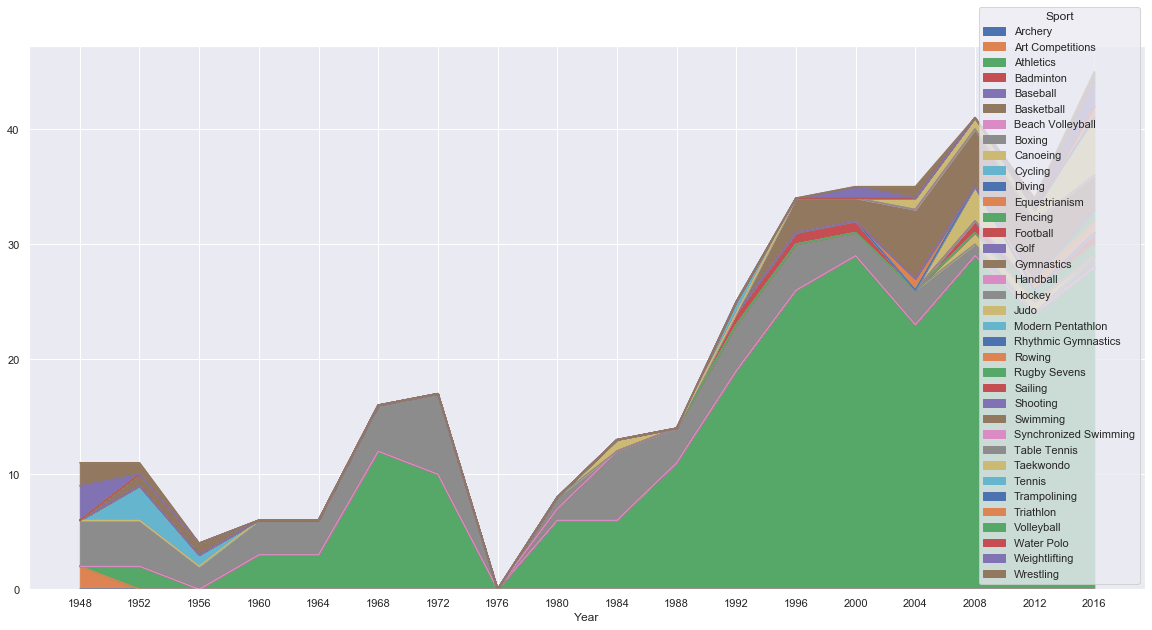

In [313]:
medals_africa = df_summer.loc[df_summer['Continent']=='Africa'].pivot_table(index='Year', columns='Sport', values='Medal_key', aggfunc='nunique')
medals_africa.plot.area(figsize=(20,10))
plt.xticks(list(medals_africa.index))
plt.show()

In [316]:
df_summer['Sex'].value_counts()

M    128417
F     57652
Name: Sex, dtype: int64

In [328]:
rainbows = ["f4be58","db4d00","f0a315","fff108","6caf00","00755c","00a3af","0052af","3700af","8000af", "ff0c0c","ff7931","f4be58","fff651","a3ff10","00e7b5","10efff","1080ff","5c10ff","bf10ff"]

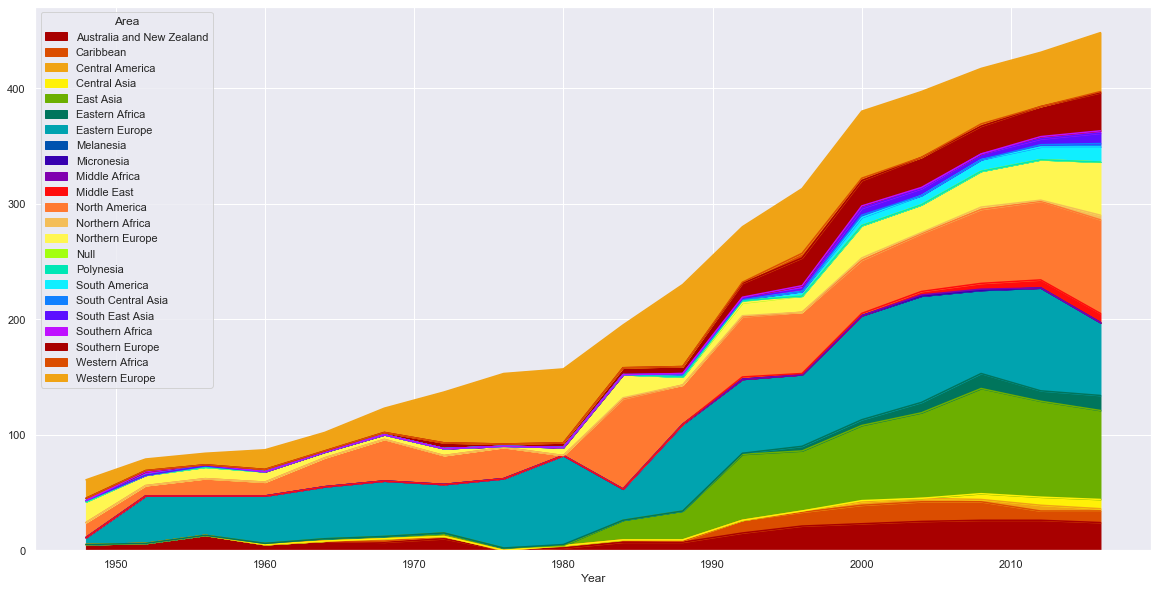

In [335]:
pv_sumwomen = df_summer[df_summer['Sex']=='F'].pivot_table(index='Year', columns='Area', values='Medal_key', aggfunc='nunique')
pv_sumwomen.plot.area(figsize=(20,10), color=rainbow)
plt.show()

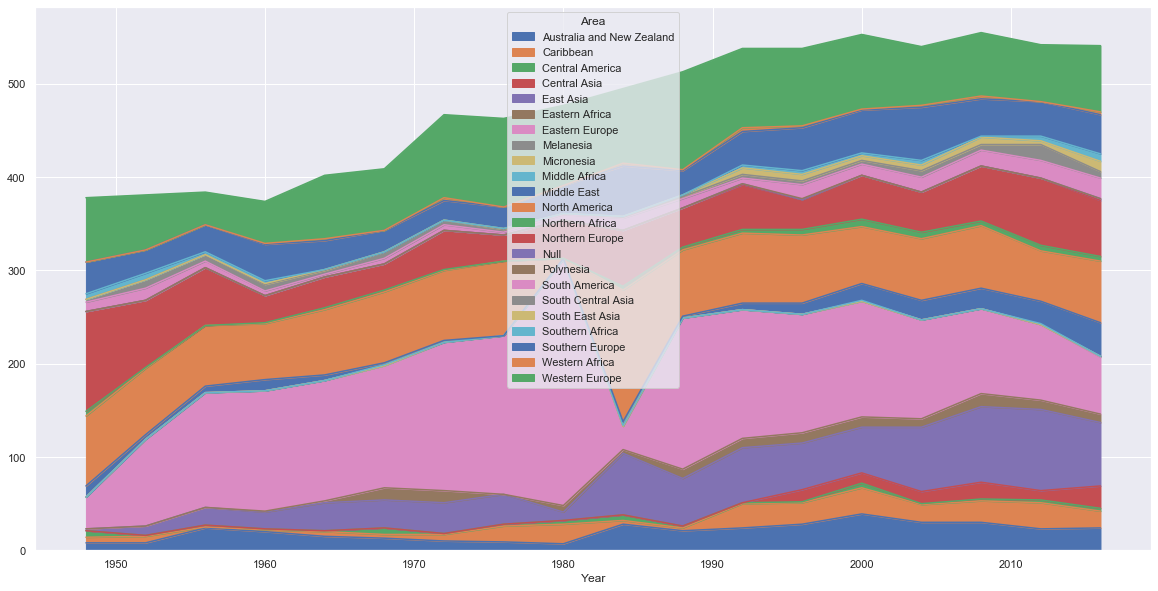

In [323]:
pv_summen = df_summer[df_summer['Sex']=='M'].pivot_table(index='Year', columns='Area', values='Medal_key', aggfunc='nunique')
pv_summen.plot.area(figsize=(20,10))
plt.show()

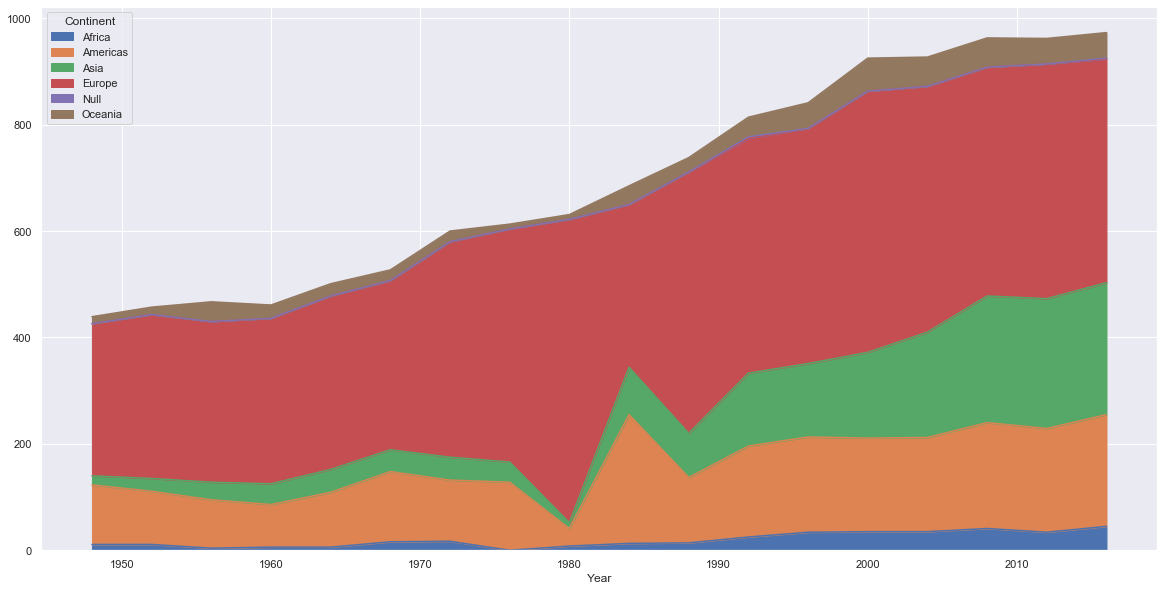

In [315]:
running_medals = df_summer.pivot_table(index='Year', columns='Continent', values='Medal_key', aggfunc='nunique')
running_medals.plot.area(figsize=(20,10))
plt.show()

In [ ]:
df_summer['

In [310]:
df_summer[df_summer['Sport']=='Athletics'].Event.value_counts()

Athletics Men's 4 x 100 metres Relay           1621
Athletics Men's Marathon                       1595
Athletics Men's 4 x 400 metres Relay           1537
Athletics Men's 100 metres                     1400
Athletics Men's 200 metres                     1137
Athletics Women's 4 x 100 metres Relay         1086
Athletics Men's 400 metres                     1056
Athletics Women's 100 metres                    982
Athletics Men's 800 metres                      971
Athletics Men's 1,500 metres                    847
Athletics Men's 5,000 metres                    777
Athletics Women's 200 metres                    765
Athletics Women's 4 x 400 metres Relay          749
Athletics Women's Marathon                      745
Athletics Men's 50 kilometres Walk              725
Athletics Men's 20 kilometres Walk              686
Athletics Men's 10,000 metres                   684
Athletics Men's 400 metres Hurdles              680
Athletics Men's Long Jump                       676
Athletics Me

***

### Dictionaries for graph formatting

In [187]:
sctr = {'sz': (15,7.5), 'tfont': 21, 'xlabl': 'Year', 'xfont': 14, 'ylabl': 'BMI',
        'yfont': 14, 's': 30, 'colors': ['b', 'g', 'y', 'purple', 'orange', 'teal'],
        'alpha': .7}

ln = {'sz': (12,6), 'lnstl': ['solid','dashed'], 'width': 2, 'colors': ['g', 'purple'],
      'lfont': 10, 'l_labls': ['Female BMI', 'Female Age', 'Male BMI', 'Male Age'],
      'xlabl': 'Year', 'tfont': 18}

br = {'sz': (20,10), 'tfnt': 22, 'xlbl': 'Year', 'xfnt': 14.5, 'ylbl': 'Number of Events',
      'yfnt': 14.5, 'c_a': ['#bfbfbf', '#93f081', '#4d009a'],
      'l_labls': ["Non-Gendered", "Women's", "Men's"], 'l_font': 12}

colorz = viridis(6)

# Summer

In [188]:
df_summer = df_olymp[df_olymp['Games'].str.contains('Summer')]

## Athlete Counts and Gender Proportions by Sport

In [189]:
# the number and percentages of women in sports
pv_summer = df_summer.pivot_table(index=df_summer['Sport'], columns='Sex', values='Name', aggfunc='nunique')
pv_summer.fillna(0, inplace=True)
pv_summer['Total'] = pv_summer.sum(axis=1)
pv_summer['%F'] = pv_summer['F']/pv_summer['Total']
pv_summer[['M', 'F', 'Total']] = pv_summer[['M', 'F', 'Total']].astype('int')
pv_summer.style.format({'%F': '{:.2%}'})

Sex,F,M,Total,%F
Sport,,,,
Aeronautics,0,1,1,0.00%
Alpinism,1,3,4,25.00%
Archery,500,613,1113,44.92%
Art Competitions,204,1610,1814,11.25%
Athletics,6527,15526,22053,29.60%
Badminton,412,399,811,50.80%
Baseball,0,761,761,0.00%
Basketball,932,2480,3412,27.32%
Basque Pelota,0,2,2,0.00%


In [190]:
# top six sports played by women in terms of numbers of players
highest_num = list(pv_summer.sort_values(by='F', ascending=False).head(6).index)

# top five sports in terms of highest percentage of women
highest_perc = pv_summer.sort_values(by='%F', ascending=False).head(11)
left_out = highest_perc.index.isin(['Softball', 'Rugby Sevens', 'Triathlon', 'Taekwondo', 'Trampolining'])
highest_perc = highest_perc.loc[~left_out]

highest_perc = list(highest_perc.index)

both_women = highest_num + highest_perc

## Average BMI for Most Common Womens' Sports

In [191]:
top_sprt = df_olymp['Sport'].isin(both_women)
sx_f = df_olymp['Sex'] == 'F'
yr_64 = df_olymp['Year'] >= 1964

df_high_women = df_olymp[top_sprt & sx_f & yr_64]

pv_high_women = df_high_women.pivot_table(index=df_high_women['Year'], columns='Sport', values='BMI', aggfunc='mean')
pv_high_women['Year'] = pv_high_women.index

### Sports with Highest Number of Women

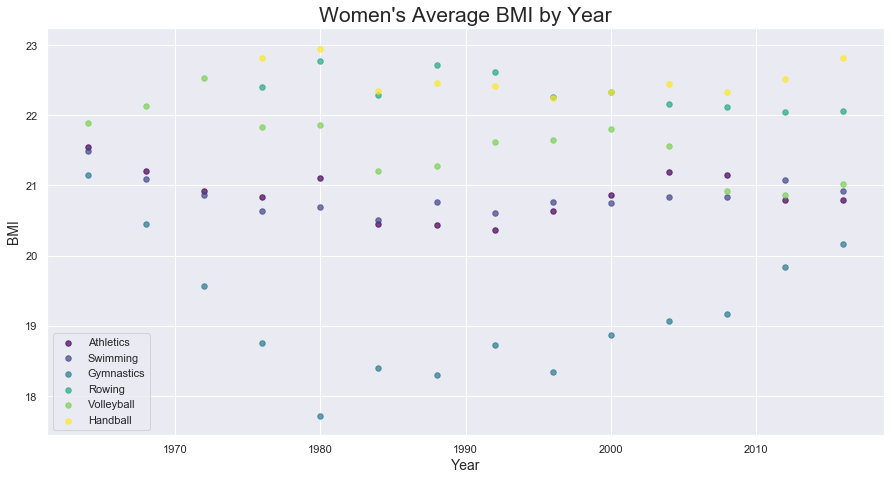

In [192]:
fig, ax = plt.subplots(figsize=sctr['sz'])

for counter, sport in enumerate(highest_num):
    ax.scatter(x=pv_high_women['Year'], y=pv_high_women[sport], color=colorz[counter], s=sctr['s'], label=sport, alpha=sctr['alpha'])

plt.title("Women's Average BMI by Year", fontsize=sctr['tfont'])
plt.xlabel(sctr['xlabl'], fontsize=sctr['xfont'])
plt.ylabel(sctr['ylabl'], fontsize=sctr['yfont'])
plt.legend()

plt.show()

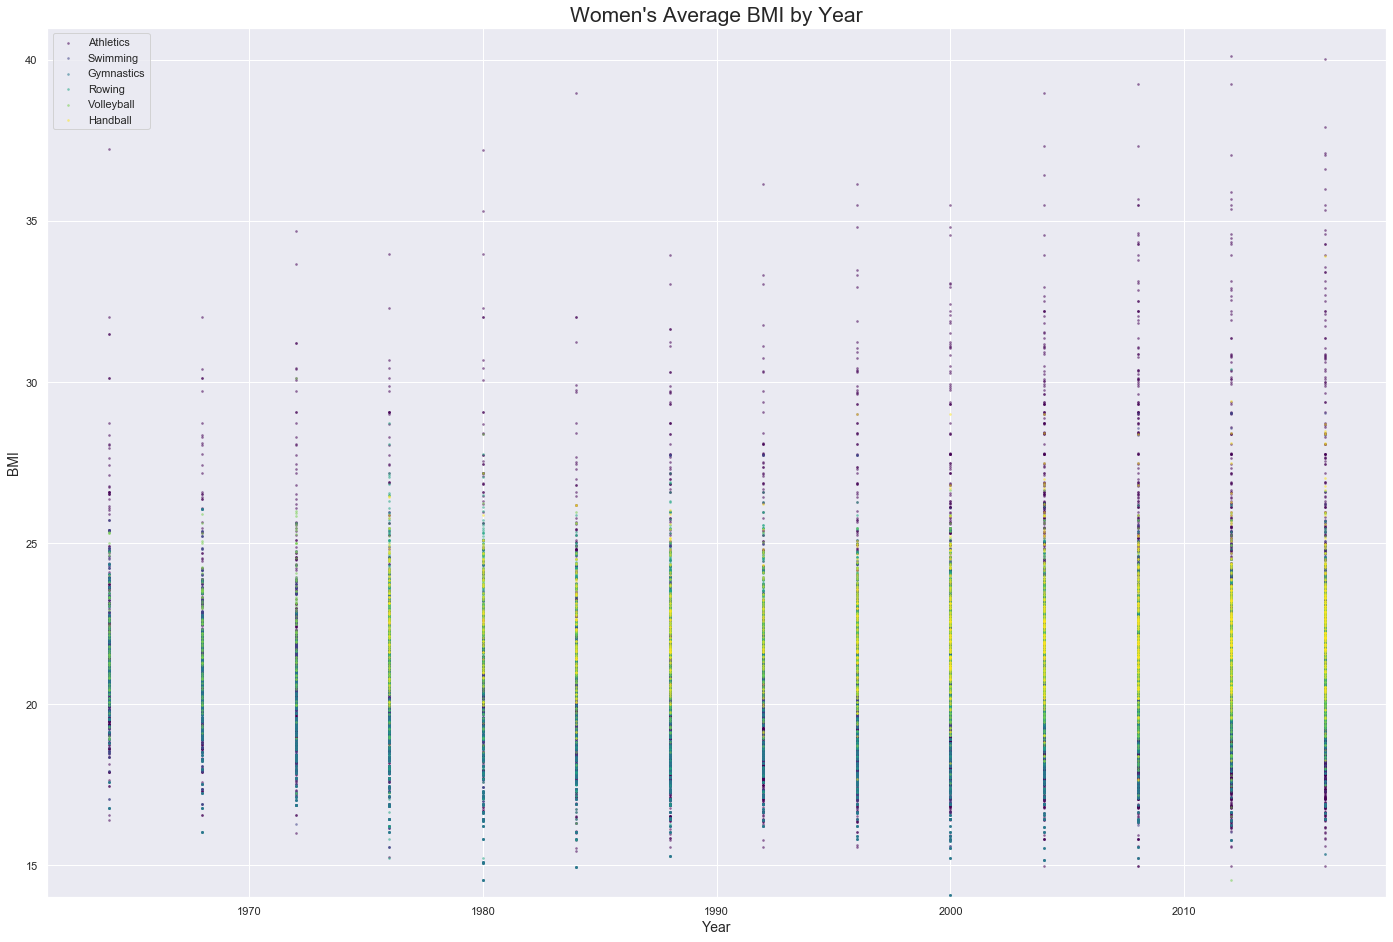

In [193]:
#### current experiment
fig, ax = plt.subplots(figsize=(24,16))

for counter, sport in enumerate(highest_num):
    spec_sport_df = df_high_women[df_high_women['Sport']==sport]
    ax.scatter(x=spec_sport_df['Year'], y=spec_sport_df['BMI'], color=colorz[counter], s=3, label=sport, alpha=.4)

plt.ylim(bottom=14, top=41)
plt.title("Women's Average BMI by Year", fontsize=sctr['tfont'])
plt.xlabel(sctr['xlabl'], fontsize=sctr['xfont'])
plt.ylabel(sctr['ylabl'], fontsize=sctr['yfont'])
plt.legend()

plt.show()

### Sports with Highest Percentage Women

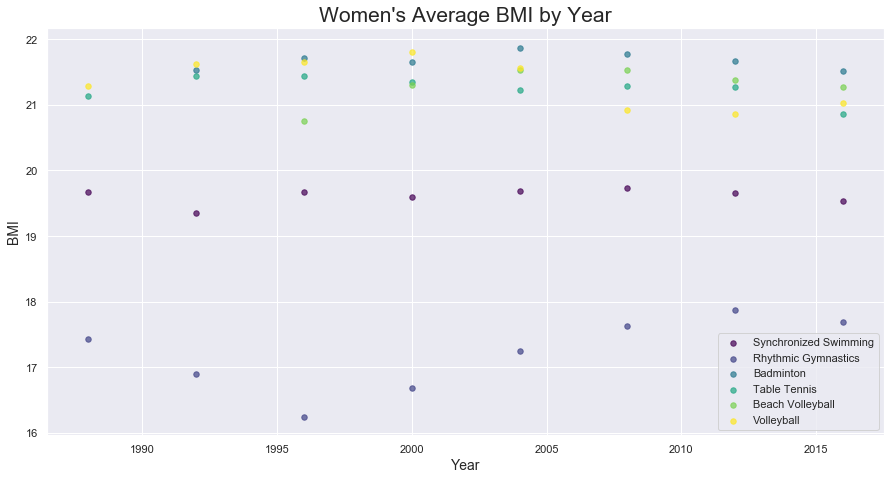

In [194]:
pv_high_women_80 = pv_high_women.loc[pv_high_women['Year']>=1988]

fig, ax = plt.subplots(figsize=sctr['sz'])

for counter, sport in enumerate(highest_perc):
    ax.scatter(x=pv_high_women_80['Year'], y=pv_high_women_80[sport], color=colorz[counter], alpha=sctr['alpha'],label=sport,
               s=sctr['s'])

plt.title("Women's Average BMI by Year", fontsize=sctr['tfont'])
plt.xlabel(sctr['xlabl'], fontsize=sctr['xfont'])
plt.ylabel(sctr['ylabl'], fontsize=sctr['yfont'])
ax.legend()

plt.show()

## Gymnastics Average Age & BMI by Gender

In [195]:
fix_age = df_olymp['Age'] > 0

In [196]:
df_gym = df_olymp.loc[(df_olymp['Sport']=='Gymnastics')&(df_olymp['Year']>=1936) & fix_age]

pv_gym = df_gym.pivot_table(index=df_gym['Year'], columns='Sex', values=['BMI', 'Age'], aggfunc='mean')

pv_gym = pv_gym.loc[:,['BMI', 'Age']]
pv_gym

BMI                   Age           
Sex           F          M          F          M
Year                                            
1936  21.388251  22.289532  22.984375  25.994337
1948  22.265625  23.258285  23.583333  28.213217
1952  21.338427  22.995742  23.095768  26.703860
1956  21.511147  23.321104  22.504785  26.906393
1960  21.178108  22.868111  21.773743  25.958511
1964  21.144238  22.629634  21.924051  25.111881
1968  20.455325  22.480185  19.620102  24.126526
1972  19.569120  22.389947  18.312500  24.101136
1976  18.758913  22.104750  17.687251  22.525641
1980  17.714368  22.063384  16.312849  22.832677
1984  18.401825  22.476707  16.825858  22.847550
1988  18.296952  22.336753  16.881226  22.107914
1992  18.721553  22.487395  16.740602  22.449516
1996  18.349689  22.538039  16.789931  22.749086
2000  18.863264  22.583759  17.661355  23.289720
2004  19.072072  22.619237  18.143984  23.765528
2008  19.172369  22.555932  18.272517  24.228164
2012  19.840249  22.477650  19.570681  23.781116
2016  20.167598  22.406490  19.887728  24.002092

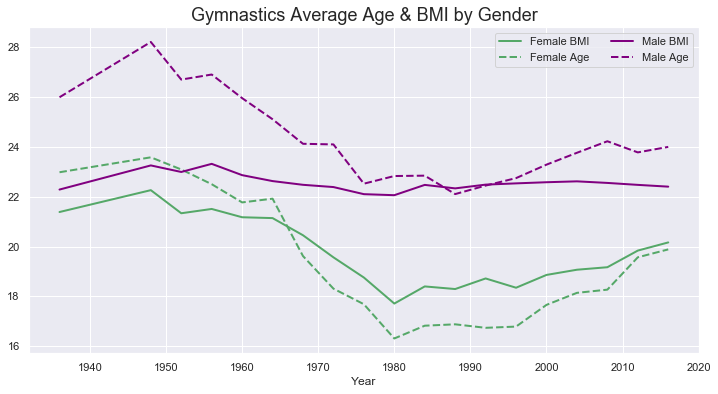

In [197]:
ax1 = pv_gym['BMI']['F'].plot.line(figsize=ln['sz'], linestyle=ln['lnstl'][0], linewidth=ln['width'], color=ln['colors'][0])
pv_gym['Age']['F'].plot.line(linestyle=ln['lnstl'][1], linewidth=ln['width'], color=ln['colors'][0], ax=ax1)
pv_gym['BMI']['M'].plot.line(linestyle=ln['lnstl'][0], linewidth=ln['width'], color=ln['colors'][1], ax=ax1)
pv_gym['Age']['M'].plot.line(linestyle=ln['lnstl'][1], linewidth=ln['width'], color=ln['colors'][1], ax=ax1)
plt.title('Gymnastics Average Age & BMI by Gender', fontsize=ln['tfont'])
plt.legend(ncol=2, labels=ln['l_labls'])

plt.show()                 

## Volleyball Average Age & BMI by Gender

In [198]:
# df_vol = df_olymp[df_olymp['Sport']=='Volleyball']
df_vol = df_olymp.loc[(df_olymp['Sport']=='Volleyball') & fix_age]
pv_vol = df_vol.pivot_table(index=df_vol['Year'], columns='Sex', values=['BMI', 'Age'], aggfunc='mean')
pv_vol = pv_vol[['BMI', 'Age']]
pv_vol

BMI                   Age           
Sex           F          M          F          M
Year                                            
1964  21.887474  23.255079  23.352941  25.801802
1968  22.134229  23.468044  23.252874  25.025210
1972  22.522495  23.480609  23.868132  24.321429
1976  21.837445  23.571061  22.927083  24.616667
1980  21.855374  23.516007  22.844444  25.257143
1984  21.201629  22.985356  22.300000  24.406780
1988  21.281801  23.185072  22.810526  25.041667
1992  21.614200  23.225805  23.415730  25.042254
1996  21.652962  23.299579  24.656716  25.297872
2000  21.796577  23.216784  24.927536  26.205674
2004  21.558246  23.287285  25.357143  27.307692
2008  20.918699  22.923792  25.450000  27.727273
2012  20.863541  23.158646  26.293706  27.006944
2016  21.020635  23.098262  26.640845  27.553191

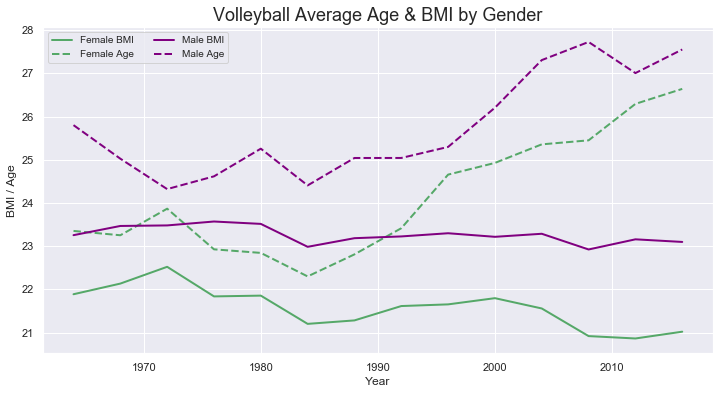

In [199]:
ax1 = pv_vol['BMI']['F'].plot.line(figsize=ln['sz'], linestyle=ln['lnstl'][0], linewidth=ln['width'], color=ln['colors'][0])
pv_vol['Age']['F'].plot.line(linestyle=ln['lnstl'][1], linewidth=ln['width'], color=ln['colors'][0], ax=ax1)
pv_vol['BMI']['M'].plot.line(linestyle=ln['lnstl'][0], linewidth=ln['width'], color=ln['colors'][1], ax=ax1)
pv_vol['Age']['M'].plot.line(linestyle=ln['lnstl'][1], linewidth=ln['width'], color=ln['colors'][1], ax=ax1)

plt.title('Volleyball Average Age & BMI by Gender', fontsize=ln['tfont'])
plt.ylabel('BMI / Age')
plt.legend(fontsize=ln['lfont'], labels=ln['l_labls'], ncol=2)

plt.show()

# Winter

## Counts & Percentages of Women by Sport

In [201]:
df_winter = df_olymp[df_olymp['Games'].str.contains('Winter')]

In [202]:
# the counts and percentages of women in sports
pv_winter = df_winter.pivot_table(index=df_winter['Sport'], columns='Sex', values='Name', aggfunc='nunique')
pv_winter.fillna(0, inplace=True)
pv_winter['Total'] = pv_winter.sum(axis=1)
pv_winter['%F'] = pv_winter['F']/pv_winter['Total']
pv_winter[['F', 'M', 'Total']] = pv_winter[['F', 'M', 'Total']].astype('int')
pv_winter.style.format({'%F': '{:.2%}'})

Sex,F,M,Total,%F
Sport,,,,
Alpine Skiing,996,1738,2734,36.43%
Alpinism,0,21,21,0.00%
Biathlon,371,764,1135,32.69%
Bobsleigh,109,1585,1694,6.43%
Cross Country Skiing,717,1683,2400,29.88%
Curling,160,186,346,46.24%
Figure Skating,811,726,1537,52.77%
Freestyle Skiing,267,359,626,42.65%
Ice Hockey,498,3343,3841,12.97%


## Average BMI in Most Common Women's Sports

In [203]:
high_num_w = list(pv_winter.sort_values(by='F', ascending=False).head(4).index)

high_perc_w = pv_winter.sort_values(by='%F', ascending=False)
excluded = high_perc_w.index.isin(['Curling', 'Freestyle Skiing', 'Short Track Speed Skating', 'Snowboarding'])
high_perc_w = list(high_perc_w.loc[~excluded].head(3).index)
both_wom_w = high_num_w + high_perc_w

pv_winter_women = df_olymp[(df_olymp['Sport'].isin(both_wom_w))&(df_olymp['Year'] >= 1952)]
pv_winter_women = pv_winter_women.pivot_table(index='Year', columns='Sport', values='BMI', aggfunc='mean')
wint_sports = pv_winter_women.columns
pv_winter_women['Year'] = pv_winter_women.index
pv_winter_women

Sport,Alpine Skiing,Cross Country Skiing,Figure Skating,Speed Skating,Year
Year,,,,,
1952,22.247577,22.077907,20.509411,22.756386,1952
1956,22.853360,22.737796,20.446262,23.568214,1956
1960,22.989860,22.639247,20.983969,23.046719,1960
1964,23.251688,22.458769,21.653639,23.115190,1964
1968,22.972778,22.476719,20.941168,22.847254,1968
1972,22.382489,22.140499,20.998262,22.541276,1972
1976,22.534803,22.140673,20.205360,22.814398,1976
1980,22.518518,21.908198,19.863010,22.647424,1980
1984,22.887378,21.661249,20.294120,22.835646,1984


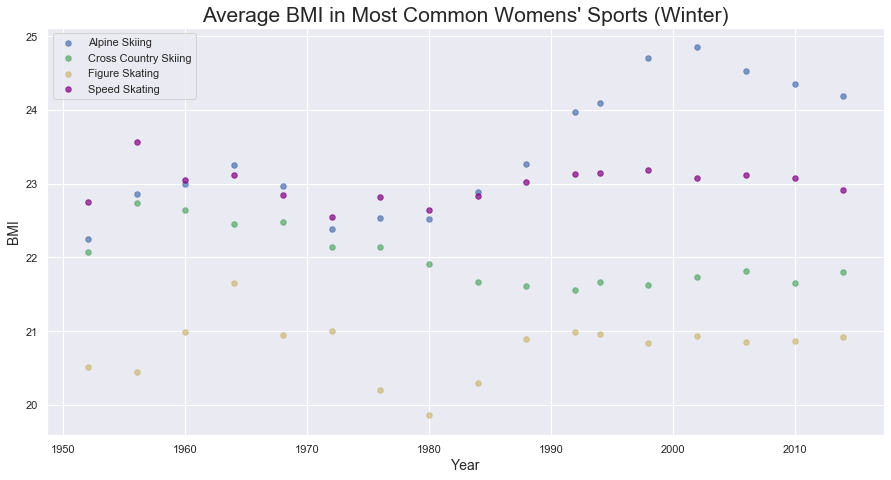

In [204]:
fig, ax = plt.subplots(figsize=sctr['sz'])

for counter, sport in enumerate(wint_sports):
    ax.scatter(x=pv_winter_women['Year'], y=pv_winter_women[sport], color=sctr['colors'][counter], alpha=sctr['alpha'], s=sctr['s'],
               label=sport)

plt.title("Average BMI in Most Common Womens' Sports (Winter)", fontsize=sctr['tfont'])
plt.xlabel(sctr['xlabl'], fontsize=sctr['xfont'])
plt.ylabel(sctr['ylabl'], fontsize=sctr['yfont'])
plt.legend()

plt.show()

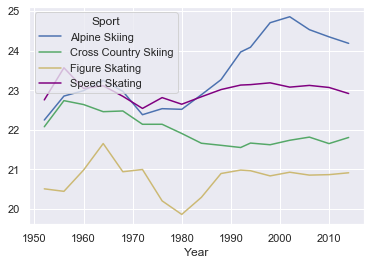

In [205]:

columns_list = [col_name for col_name in pv_winter_women.columns if col_name != "Year"]
pv_winter_women[columns_list].plot.line(color=sctr['colors'])

plt.show()

## Speed Skating Average Age & BMI by Gender

In [206]:
af_64 = df_olymp['Year'] >= 1964
sp_sk = df_olymp['Sport'] == 'Speed Skating'
df_skate = df_olymp[af_64 & sp_sk & fix_age]

pv_skate = df_skate.pivot_table(index=df_skate['Year'], columns='Sex', values=['BMI', 'Age'], aggfunc='mean')

pv_skate = pv_skate[['BMI', 'Age']]
pv_skate

BMI                   Age           
Sex           F          M          F          M
Year                                            
1964  22.595672  23.487887  23.008772  24.150289
1968  21.919064  23.485029  21.752212  24.365269
1972  21.883947  23.127266  21.982609  24.674419
1976  22.074996  23.411346  22.169811  24.411348
1980  21.556643  23.520049  21.781250  23.309524
1984  22.018344  23.374527  21.976744  23.412060
1988  22.351024  23.499174  23.158273  23.893048
1992  22.152662  23.854999  23.405229  23.363184
1994  22.149726  23.953288  23.615385  23.760000
1998  22.071999  24.194031  24.531646  24.610169
2002  21.978640  24.023180  25.441558  25.853933
2006  22.176918  23.978246  25.338889  25.793970
2010  22.187539  23.925456  25.644444  25.241935
2014  21.965407  23.842474  26.011050  25.454545

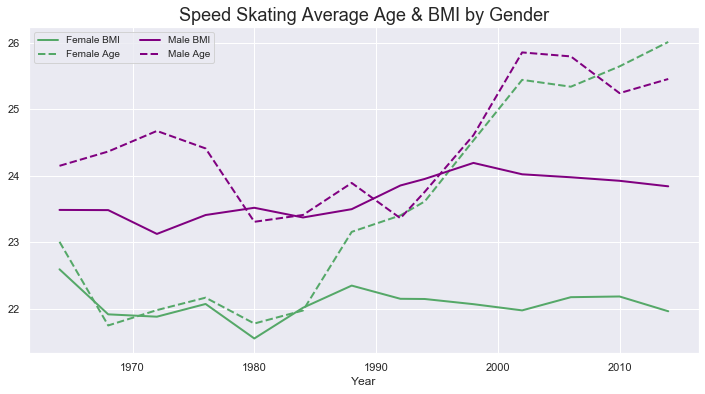

In [207]:
ax1 = pv_skate['BMI']['F'].plot.line(figsize=ln['sz'], linestyle=ln['lnstl'][0], linewidth=ln['width'], color=ln['colors'][0])
pv_skate['Age']['F'].plot.line(linestyle=ln['lnstl'][1], linewidth=ln['width'], color=ln['colors'][0], ax=ax1)
pv_skate['BMI']['M'].plot.line(linestyle=ln['lnstl'][0], linewidth=ln['width'], color=ln['colors'][1], ax=ax1)
pv_skate['Age']['M'].plot.line(linestyle=ln['lnstl'][1], linewidth=ln['width'], color=ln['colors'][1], ax=ax1)
plt.title('Speed Skating Average Age & BMI by Gender', fontsize=ln['tfont'])
plt.legend(fontsize=ln['lfont'], labels=ln['l_labls'], ncol=2)
plt.show()

## Cross Country Skiing Average Age & BMI by Gender

In [208]:
df_ski = df_olymp[(df_olymp['Sport']=='Cross Country Skiing') & fix_age]
pv_ski = df_ski.pivot_table(index=df_ski['Year'], columns='Sex', values=['BMI', 'Age'], aggfunc='mean')
pv_ski['Year'] = pv_ski.index
pv_ski = pv_ski[pv_ski['Year'] >= 1960] 
pv_ski = pv_ski[['BMI', 'Age']]

pv_ski

BMI                   Age           
Sex           F          M          F          M
Year                                            
1960  21.772444  22.935229  26.128205  27.040000
1964  21.677602  22.750052  25.593407  27.041494
1968  21.808815  22.710226  27.173913  26.391129
1972  21.210966  22.655451  24.855932  25.649770
1976  20.812605  22.814820  23.427419  25.402214
1980  20.409010  22.752052  23.972222  24.855721
1984  20.459432  22.405232  24.291667  24.656140
1988  20.325505  22.486827  24.090476  25.216981
1992  20.308204  22.521204  24.943262  24.577011
1994  20.413501  22.629096  25.289286  25.919220
1998  20.487945  22.600938  26.020588  26.488550
2002  20.659083  22.633622  26.375706  27.071429
2006  20.761801  22.683419  26.016393  26.560538
2010  20.709564  22.522404  26.806268  27.176471
2014  20.715745  22.713619  27.224138  27.230216

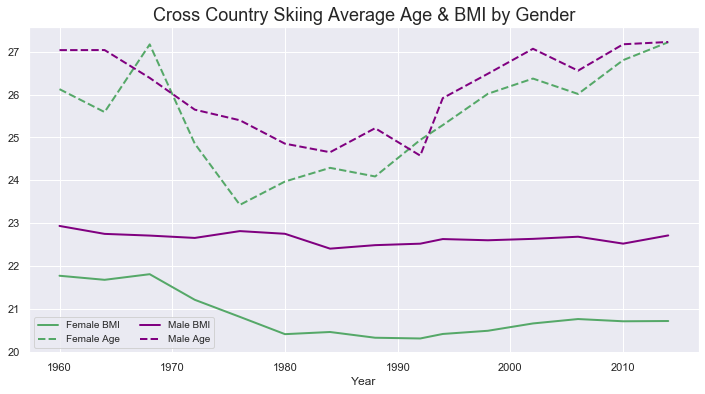

In [209]:
ax1 = pv_ski['BMI']['F'].plot.line(figsize=ln['sz'], linestyle=ln['lnstl'][0], linewidth=ln['width'], color=ln['colors'][0])
pv_ski['Age']['F'].plot.line(linestyle=ln['lnstl'][1], linewidth=ln['width'], color=ln['colors'][0], ax=ax1)
pv_ski['BMI']['M'].plot.line(linestyle=ln['lnstl'][0], linewidth=ln['width'], color=ln['colors'][1], ax=ax1)
pv_ski['Age']['M'].plot.line(linestyle=ln['lnstl'][1], linewidth=ln['width'], color=ln['colors'][1], ax=ax1)
plt.title('Cross Country Skiing Average Age & BMI by Gender', fontsize=ln['tfont'])
plt.legend(fontsize=ln['lfont'], labels=ln['l_labls'], ncol=2)
plt.show()

# Both Seasons

## Event Gender Percentages

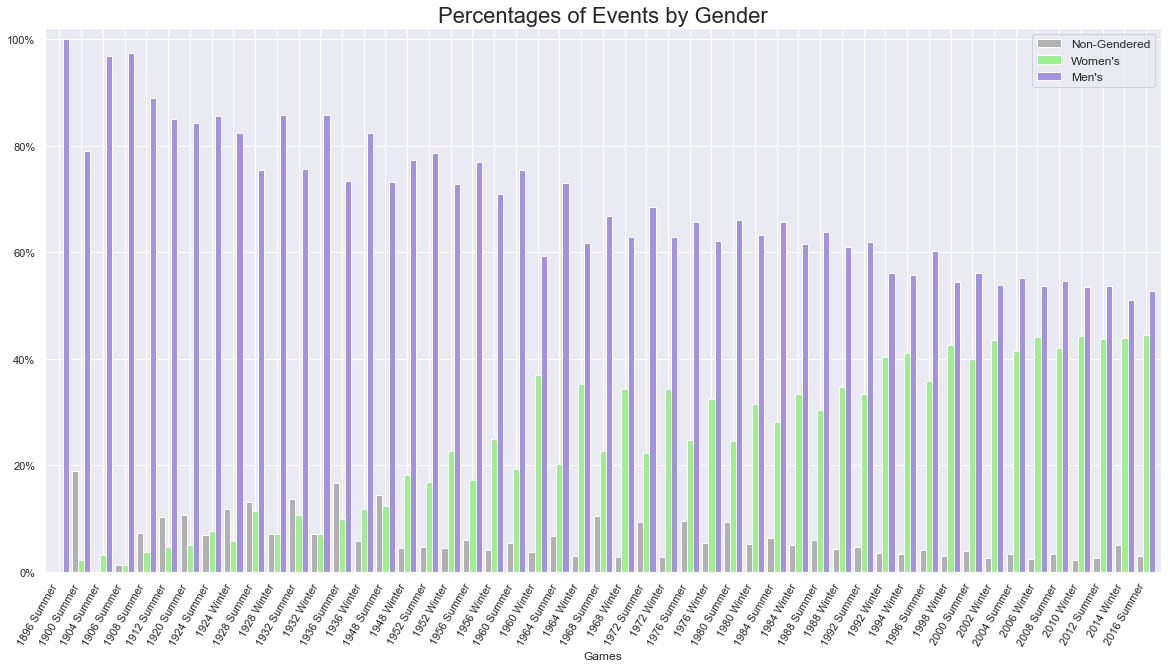

In [211]:
# pivot table of the number of events by gender
pv_gen_event = df_olymp.pivot_table(index=df_olymp['Games'], columns='Event_gender', values='Event', aggfunc='nunique')
colz = pv_gen_event.columns
pv_gen_event['Total'] = pv_gen_event.sum(axis=1)

for col in colz:
    pv_gen_event[col] = (pv_gen_event[col]/pv_gen_event['Total'])*100

pv_gen_event = pv_gen_event[colz]

# bar graph of the number of different mens/womens events
ax = pv_gen_event.plot.bar(figsize=(20,10), color=['#b1b1b1', '#9BF28A', '#A490E6'], width=.85)
plt.title('Percentages of Events by Gender', fontsize=22)
plt.xticks(rotation=60, ha='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylim(top=102)
plt.legend(labels=br['l_labls'], fontsize=br['l_font'])
plt.show()

## Summer`

In [213]:
# makes lists of just the years
pv_summer_event = df_summer.pivot_table(index='Year', columns='Event_gender', values='Event', aggfunc='nunique')
years_summer = list(pv_summer_event.index)

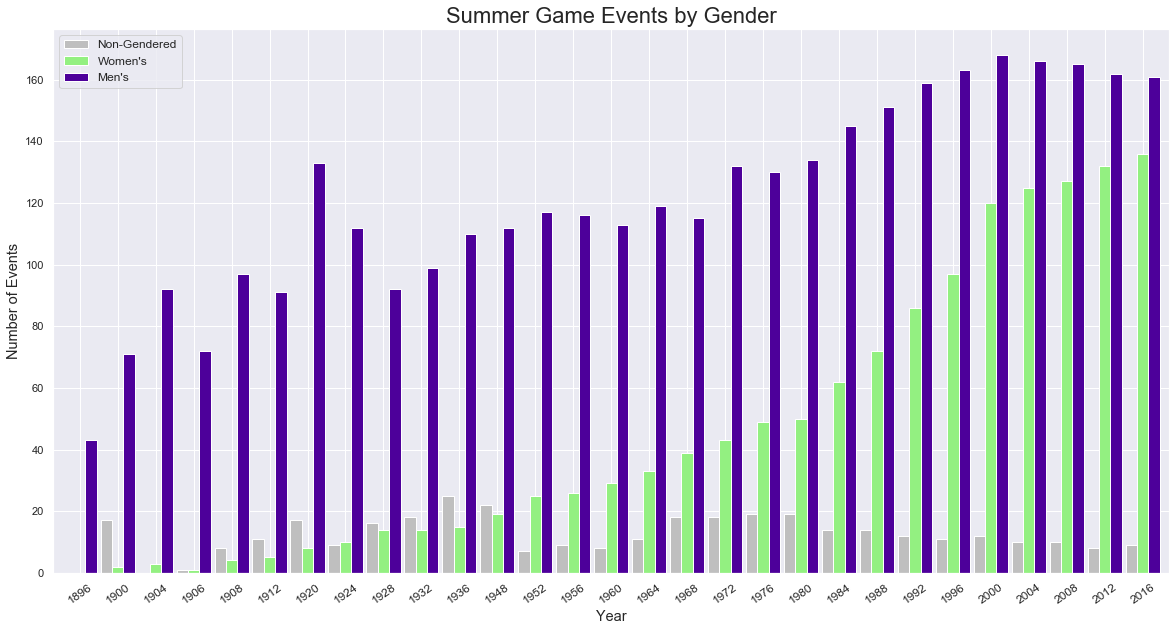

In [214]:
# BAR GRAPH FOR SUMMER EVENTS
pv_summer_event.plot.bar(figsize=br['sz'], color=br['c_a'], width=.9)
plt.title('Summer Game Events by Gender', fontsize=br['tfnt'])
plt.xlabel(br['xlbl'], fontsize=br['xfnt'])
plt.ylabel(br['ylbl'], fontsize=br['yfnt'])
# set xtick locations with numpy.arange (evenly spaced points between 0 up to (but not including) the len(list)
# then it sets the labels as the without summer list that was generated in the cell above
plt.xticks(np.arange(0, (len(pv_summer_event.index))), years_summer, rotation=35, ha='center', fontsize=12)
plt.legend(labels=br['l_labls'], fontsize=br['l_font'])
plt.show()

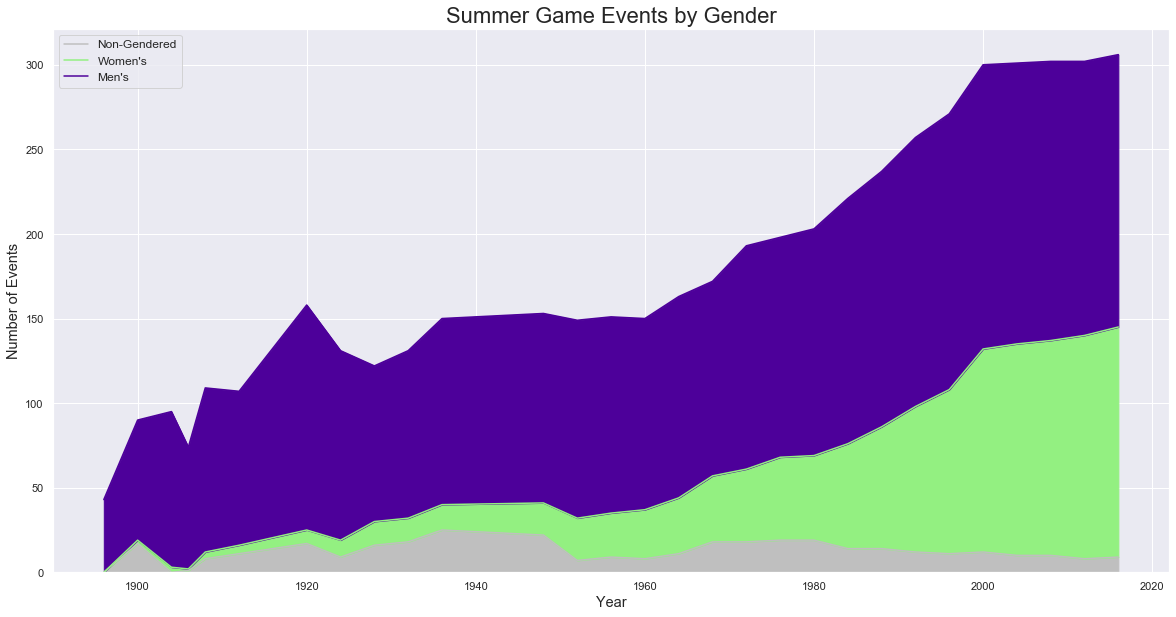

In [215]:
# AREA GRAPH FOR SUMMER EVENTS BY GENDER
pv_summer_event.plot.area(figsize=br['sz'], color=br['c_a'])
plt.title('Summer Game Events by Gender', fontsize=br['tfnt'])
plt.xlabel(br['xlbl'], fontsize=br['xfnt'])
plt.ylabel(br['ylbl'], fontsize=br['yfnt'])
plt.legend(labels=br['l_labls'], fontsize=br['l_font'])
plt.show()

## Winter

In [217]:
pv_winter_event = df_winter.pivot_table(index='Year', columns='Event_gender', values='Event', aggfunc='nunique')
years_winter = list(pv_winter_event.index)

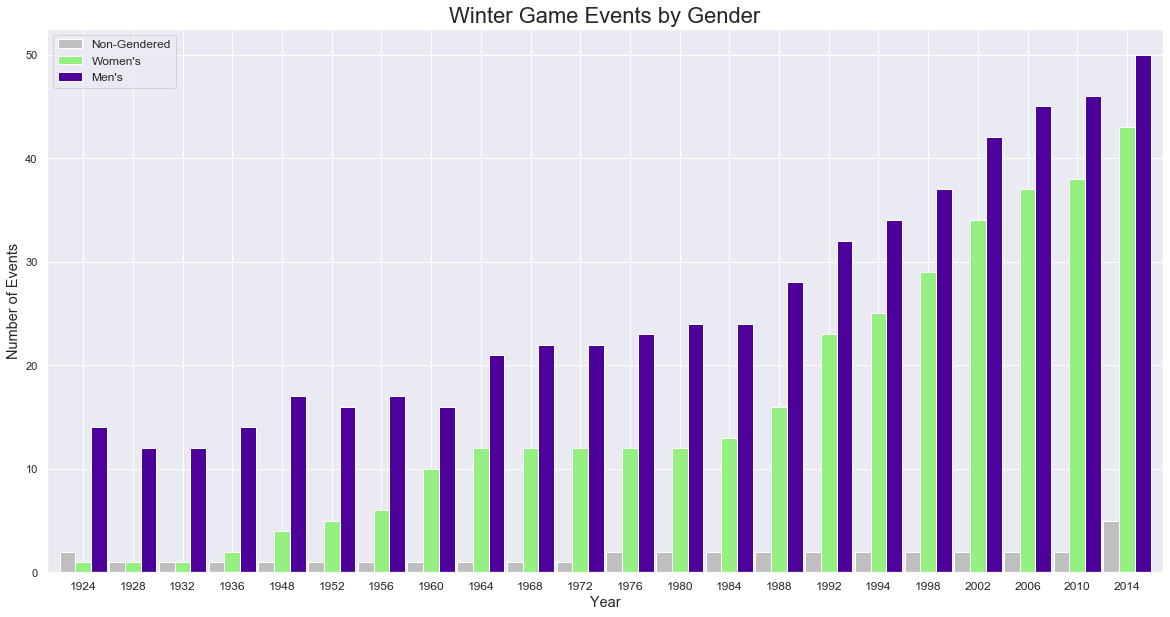

In [218]:
# BAR GRAPH FOR WINTER EVENTS BY GENDER
pv_winter_event.plot.bar(figsize=br['sz'], color=br['c_a'], width=.95)
plt.title('Winter Game Events by Gender', fontsize=br['tfnt'])
plt.xlabel(br['xlbl'], fontsize=br['xfnt'])
plt.ylabel(br['ylbl'], fontsize=br['yfnt'])
plt.xticks(np.arange(0, (len(pv_winter_event.index))), years_winter, rotation=0, ha='center', fontsize=12)

plt.legend(labels=br['l_labls'], fontsize=br['l_font'])

plt.show()

## Both Seasons 

### Competitor Gender Percentages

In [219]:
# PIVOT TABLE TO COUNT THE NUMBER OF MALE OR FEMALE COMPETITORS IN EACH GAME
df_games_pvt = df_olymp.pivot_table(index=df_olymp['Games'], columns=['Sex'], values='Name', aggfunc='nunique', fill_value=0)
# df_games_pvt
# colz = df_games_pvt.columns
df_games_pvt = df_games_pvt.apply(lambda x: x/x.sum(), axis=1)
    
# df_games_pvt = df_games_pvt[colz]
df_games_pvt

Sex,F,M
Games,,
1896 Summer,0.000000,1.000000
1900 Summer,0.018852,0.981148
1904 Summer,0.009231,0.990769
1906 Summer,0.007134,0.992866
1908 Summer,0.021739,0.978261
1912 Summer,0.022001,0.977999
1920 Summer,0.029159,0.970841
1924 Summer,0.047912,0.952088
1924 Winter,0.041534,0.958466


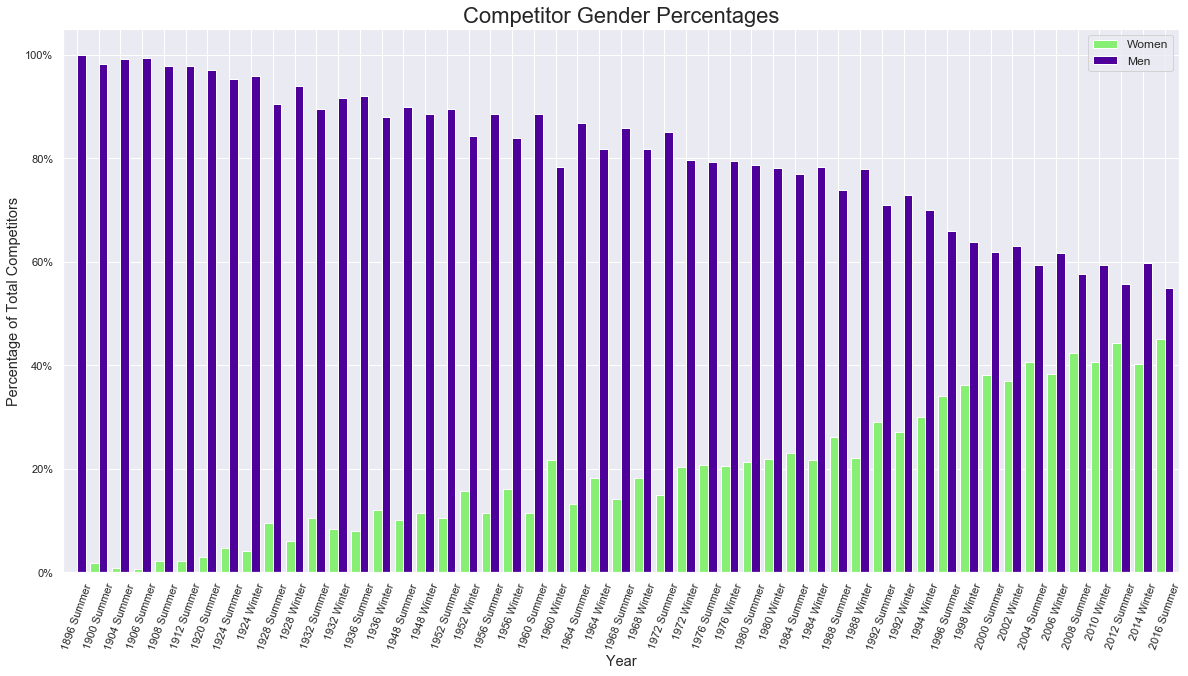

In [220]:
# BAR GRAPH OF Percentage OF COMPETITORS BY GENDER
df_games_pvt.plot.bar(figsize=br['sz'], color=['#87EF73', '#4d009a'], width=.8)
plt.title('Competitor Gender Percentages', fontsize=br['tfnt'])
plt.xlabel(br['xlbl'], fontsize=br['xfnt'])
plt.ylabel('Percentage of Total Competitors', fontsize=br['yfnt'])
plt.xticks(rotation=70, ha='center')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
plt.legend(labels=['Women', 'Men'], fontsize=br['l_font'])
plt.show()

## Summer Percentage of Competitors by Gender by Year

In [221]:
format_dict = {'F%': "{:.1%}", 'M%': "{:.1%}", 'F % Change': "{:+.1%}", 'M % Change': "{:+.1%}",
               'F ratio % change': "{:+.1%}", 'M ratio % change': "{:+.1%}"}

bu_gn = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c','#074400']
rv_pu = ['#3f007d', '#54278f', '#6a51a3', '#807dba', '#9e9ac8', '#bcbddc']
grn = ['#003615']

bu_gn = ListedColormap(sns.color_palette(bu_gn).as_hex())
rv_pu = ListedColormap(sns.color_palette(rv_pu).as_hex())
grn = ListedColormap(sns.color_palette(grn).as_hex())

pv_summer_athletes = df_summer.pivot_table(index='Year', columns='Sex', values='Name', aggfunc='nunique', fill_value=0)
pv_summer_athletes['Total'] = pv_summer_athletes.sum(axis=1)
pv_summer_athletes['F%'] = pv_summer_athletes['F']/pv_summer_athletes['Total']
pv_summer_athletes['M%'] = pv_summer_athletes['M']/pv_summer_athletes['Total']
pv_summer_athletes['F % Change'] = pv_summer_athletes['F'].pct_change()
pv_summer_athletes['M % Change'] = pv_summer_athletes['M'].pct_change()

### questionable add in
pv_summer_athletes['F ratio % change'] = pv_summer_athletes['F%'].pct_change()
pv_summer_athletes['M ratio % change'] = pv_summer_athletes['M%'].pct_change()

above = pv_summer_athletes['F % Change'].between(0.008,6)
below = pv_summer_athletes['F % Change'] < 0

pv_summer_athletes = pv_summer_athletes.style
pv_summer_athletes = pv_summer_athletes.background_gradient(cmap=grn, subset=pd.IndexSlice[1908, ['F % Change']])
pv_summer_athletes = pv_summer_athletes.background_gradient(cmap=bu_gn, subset=pd.IndexSlice[above, ['F % Change']])
pv_summer_athletes = pv_summer_athletes.background_gradient(cmap=rv_pu, subset=pd.IndexSlice[below, ['F % Change']])
pv_summer_athletes = pv_summer_athletes.format(format_dict)

pv_summer_athletes
##### change in ratio of percentages

Sex,F,M,Total,F%,M%,F % Change,M % Change,F ratio % change,M ratio % change
Year,,,,,,,,,
1896,0,176,176,0.0%,100.0%,+nan%,+nan%,+nan%,+nan%
1900,23,1197,1220,1.9%,98.1%,+inf%,+580.1%,+inf%,-1.9%
1904,6,644,650,0.9%,99.1%,-73.9%,-46.2%,-51.0%,+1.0%
1906,6,835,841,0.7%,99.3%,+0.0%,+29.7%,-22.7%,+0.2%
1908,44,1980,2024,2.2%,97.8%,+633.3%,+137.1%,+204.7%,-1.5%
1912,53,2356,2409,2.2%,97.8%,+20.5%,+19.0%,+1.2%,-0.0%
1920,78,2597,2675,2.9%,97.1%,+47.2%,+10.2%,+32.5%,-0.7%
1924,156,3100,3256,4.8%,95.2%,+100.0%,+19.4%,+64.3%,-1.9%
1928,312,2934,3246,9.6%,90.4%,+100.0%,-5.4%,+100.6%,-5.1%


## Winter Games Percentage by Gender

In [222]:
pv_winter_athletes = df_winter.pivot_table(index='Year', columns='Sex', values='Name', aggfunc='nunique')
pv_winter_athletes['Total'] = pv_winter_athletes.sum(axis=1)
pv_winter_athletes['F%'] = pv_winter_athletes['F']/pv_winter_athletes['Total']
pv_winter_athletes['M%'] = pv_winter_athletes['M']/pv_winter_athletes['Total']
pv_winter_athletes['F % Change'] = pv_winter_athletes['F'].pct_change()
pv_winter_athletes['M % Change'] = pv_winter_athletes['M'].pct_change()

pv_winter_athletes = pv_winter_athletes.style.format(format_dict)
pv_winter_athletes

Sex,F,M,Total,F%,M%,F % Change,M % Change
Year,,,,,,,
1924,13,300,313,4.2%,95.8%,+nan%,+nan%
1928,28,433,461,6.1%,93.9%,+115.4%,+44.3%
1932,21,231,252,8.3%,91.7%,-25.0%,-46.7%
1936,80,588,668,12.0%,88.0%,+281.0%,+154.5%
1948,77,591,668,11.5%,88.5%,-3.7%,+0.5%
1952,109,585,694,15.7%,84.3%,+41.6%,-1.0%
1956,132,689,821,16.1%,83.9%,+21.1%,+17.8%
1960,144,521,665,21.7%,78.3%,+9.1%,-24.4%
1964,200,894,1094,18.3%,81.7%,+38.9%,+71.6%


# Gender Percentages of Competitors in Mixed-gender Sports Events

## Summer

In [223]:
# dataframe only including events that are agendered
df_no_gender = df_summer[df_summer['Event_gender'] == 'A']

# pivot table for counting the number of competitors in each nongendered game
pv_no_gender = df_no_gender.pivot_table(index='Year', columns='Sex', values='Name', aggfunc='nunique')
pv_no_gender['Total'] = pv_no_gender.sum(axis=1)

# add columns for the percentage of male or female competitors
pv_no_gender['F%'] = pv_no_gender['F']/pv_no_gender['Total']
pv_no_gender['M%'] = pv_no_gender['M']/pv_no_gender['Total']

pv_no_gender = pv_no_gender.style.format(format_dict)
pv_no_gender

Sex,F,M,Total,F%,M%
Year,,,,,
1900,12,163,175,6.9%,93.1%
1906,5,5,10,50.0%,50.0%
1908,5,79,84,6.0%,94.0%
1912,12,153,165,7.3%,92.7%
1920,26,134,160,16.2%,83.8%
1924,43,253,296,14.5%,85.5%
1928,40,457,497,8.0%,92.0%
1932,75,569,644,11.6%,88.4%
1936,35,666,701,5.0%,95.0%


## Winter

In [224]:
df_no_gender_w = df_winter[df_winter['Event_gender'] == 'A']

pv_no_gender_w = df_no_gender_w.pivot_table(index='Year', columns='Sex', values='Name', aggfunc='count')
pv_no_gender_w['Total'] = pv_no_gender_w.sum(axis=1)

pv_no_gender_w['F%'] = pv_no_gender_w['F']/pv_no_gender_w['Total']
pv_no_gender_w['M%'] = pv_no_gender_w['M']/pv_no_gender_w['Total']

pv_no_gender_w = pv_no_gender_w.style.format(format_dict)
pv_no_gender_w

Sex,F,M,Total,F%,M%
Year,,,,,
1924,9,30,39,23.1%,76.9%
1928,13,13,26,50.0%,50.0%
1932,7,7,14,50.0%,50.0%
1936,18,18,36,50.0%,50.0%
1948,15,15,30,50.0%,50.0%
1952,13,13,26,50.0%,50.0%
1956,11,11,22,50.0%,50.0%
1960,13,13,26,50.0%,50.0%
1964,17,17,34,50.0%,50.0%


# Summer

### Percentage of Competitors by Continent

In [225]:
pv_cont = df_summer.pivot_table(index='Year', columns='Continent', values='Name', aggfunc='count', fill_value=0)
colz = pv_cont.columns
pv_cont['Total'] = pv_cont.sum(axis=1)

pc_colz = []
for col_name in colz:
    cont_perc = '%s %%F' % col_name
    pv_cont[cont_perc] = pv_cont[col_name]/pv_cont['Total']
    pc_colz.append(cont_perc)
    
pv_cont_sty = pv_cont[pc_colz]
pv_cont_sty = pv_cont_sty.style.format("{:.2%}")

pv_cont_sty

Continent,Africa %F,Americas %F,Asia %F,Europe %F,Null %F,Oceania %F
Year,,,,,,
1896,0.00%,7.11%,0.00%,91.58%,0.00%,1.32%
1900,0.00%,8.16%,0.31%,91.17%,0.00%,0.36%
1904,0.61%,90.47%,0.00%,8.46%,0.00%,0.46%
1906,0.29%,4.90%,0.12%,94.11%,0.00%,0.58%
1908,1.06%,11.87%,0.00%,85.52%,0.00%,1.55%
1912,1.39%,11.19%,0.27%,86.16%,0.05%,0.94%
1920,2.77%,13.96%,0.77%,81.69%,0.00%,0.82%
1924,1.41%,15.06%,1.64%,80.62%,0.00%,1.26%
1928,1.70%,15.24%,2.52%,79.69%,0.00%,0.84%


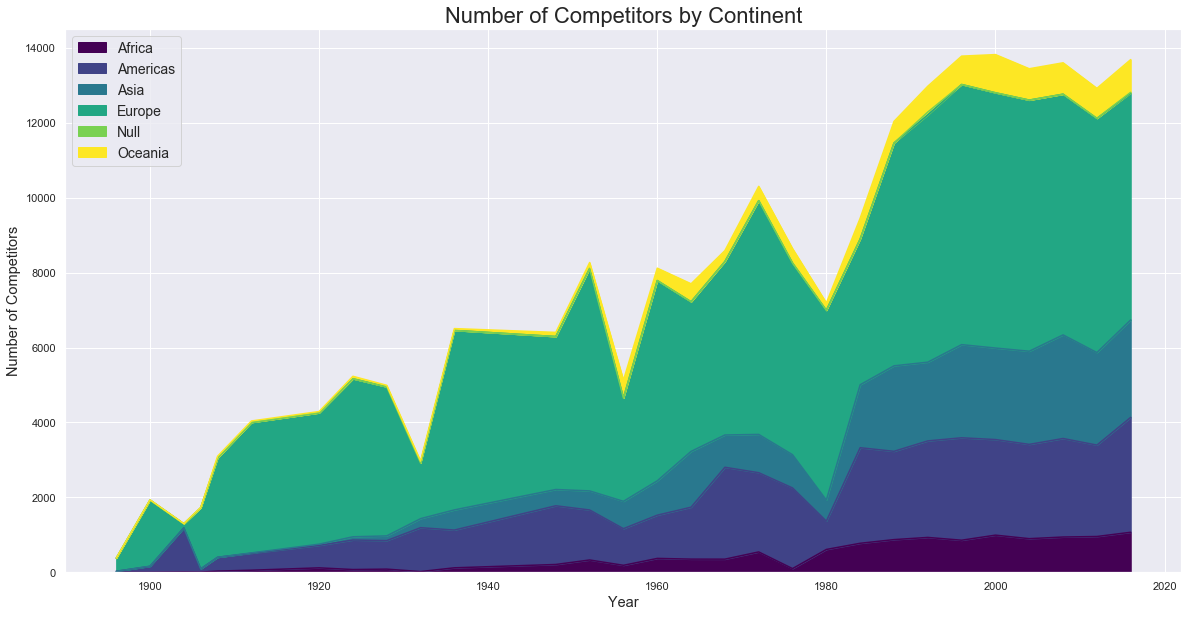

In [226]:
# AREA GRAPH FOR SUMMER EVENTS BY GENDER
pv_cont_cnt = pv_cont[colz]

pv_cont_cnt.plot.area(figsize=br['sz'], color=colorz)
plt.title('Number of Competitors by Continent', fontsize=br['tfnt'])
plt.xlabel(br['xlbl'], fontsize=br['xfnt'])
plt.ylabel('Number of Competitors', fontsize=br['yfnt'])
plt.legend(fontsize=14)
plt.show()

### Percentage of Female Competitors by Continent/Year

In [ ]:
pv_mf_ratio = df_summer.pivot_table(index='Year', columns=['Continent', 'Sex'], values='Name', aggfunc='nunique', fill_value=0)

cols = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']
perc_cols = []

for col in cols:
    col_perc = '%s %%F' % col
    pv_mf_ratio[col_perc] = pv_mf_ratio[col]['F']/pv_mf_ratio[col].sum(axis=1)
    perc_cols.append(col_perc)

all_cols = cols + perc_cols

pv_mf_ratio = pv_mf_ratio[all_cols]
pv_mf_ratio = pv_mf_ratio.style.format("{:.2%}", subset=perc_cols)
pv_mf_ratio

### Percentage of Competitors by Gender/Continent/Sport

In [ ]:
mod_summer = df_summer[df_summer['Year'] >= 2000]
pv_mod_summer = mod_summer.pivot_table(index='Sport', columns=['Continent', 'Sex'], values='Name', aggfunc='nunique', fill_value=0)

pv_mod_summer['Total'] = pv_mod_summer.sum(axis=1)
pv_mod_summer['Total %F'] = pv_mod_summer['Africa']['F']+pv_mod_summer['Oceania']['F']+pv_mod_summer['Asia']['F']+pv_mod_summer['Europe']['F']+pv_mod_summer['Americas']['F']+pv_mod_summer['Null']['F']
pv_mod_summer['Total %F'] = pv_mod_summer['Total %F']/pv_mod_summer['Total']

#for loop to make percentage columns for each continent
conts = ['Africa', 'Americas', 'Asia', 'Europe', 'Null', 'Oceania']
perc_conts = []

for cont in conts:
    cont_perc = '%s %%F' % cont
    pv_mod_summer[cont_perc] = pv_mod_summer[cont]['F']/pv_mod_summer[cont].sum(axis=1)
    perc_conts.append(cont_perc)

total_columns = ['Total %F']
all_columns = conts + perc_conts + total_columns
percs = perc_conts + total_columns

pv_mod_summer = pv_mod_summer[all_columns]

pv_mod_summer.style.format("{:.2%}", subset=percs)

In [ ]:
pv_reg = mod_summer.pivot_table(index=['Continent','Area'], columns=['Year', 'Sex'], values='Name', aggfunc='nunique')
pv_reg

# Winter

### Percentage of Competitors by Continent

In [ ]:
pv_cont_w = df_winter.pivot_table(index='Year', columns='Continent', values='Name', aggfunc='nunique', fill_value=0)
pv_cont_w['Total'] = pv_cont_w.sum(axis=1)

cols = ['Africa', 'Americas',  'Asia',  'Europe', 'Null', 'Oceania']

for col_name in pv_cont_w.columns:
    pv_cont_w[col_name] = pv_cont_w[col_name]/pv_cont_w['Total']
    
pv_cont_w = pv_cont_w[cols]

pv_cont_w.style.format("{:.2%}")

### Percentage of Female Competitors by Continent/Year

In [ ]:
pv_mf_ratio_w = df_winter.pivot_table(index='Year', columns=['Continent', 'Sex'], values='Name', aggfunc='nunique', fill_value=0)

cols = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']
perc_cols = []

for col in cols:
    col_perc = '%s %%F' % col
    pv_mf_ratio_w[col_perc] = pv_mf_ratio_w[col]['F']/pv_mf_ratio_w[col].sum(axis=1)
    perc_cols.append(col_perc)

all_cols = cols + perc_cols

pv_mf_ratio_w = pv_mf_ratio_w[all_cols]
pv_mf_ratio_w = pv_mf_ratio_w.style.format("{:.2%}", subset=perc_cols)
pv_mf_ratio_w

### Percentage of Competitors by Gender/Continent/Sport

In [ ]:
mod_winter = df_winter[df_winter['Year'] >= 2000]
pv_mod_winter = mod_winter.pivot_table(index='Sport', columns=['Continent', 'Sex'], values='Name', aggfunc='nunique', fill_value=0)

pv_mod_winter['Total'] = pv_mod_winter.sum(axis=1)
pv_mod_winter['Total %F'] = pv_mod_winter['Africa']['F']+pv_mod_winter['Oceania']['F']+pv_mod_winter['Asia']['F']+pv_mod_winter['Europe']['F']+pv_mod_winter['Americas']['F']
pv_mod_winter['Total %F'] = pv_mod_winter['Total %F']/pv_mod_winter['Total']

#for loop to make percentage columns for each continent
conts = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']
perc_conts = []

for cont in conts:
    cont_perc = '%s %%F' % cont
    pv_mod_winter[cont_perc] = pv_mod_winter[cont]['F']/pv_mod_winter[cont].sum(axis=1)
    perc_conts.append(cont_perc)

total_columns = ['Total %F']
all_columns = conts + perc_conts + total_columns
percs = perc_conts + total_columns

pv_mod_winter = pv_mod_winter[all_columns]

pv_mod_winter.style.format("{:.2%}", subset=percs)

In [ ]:
#separate gymnastics dataframes by gender
gymnasts = df_summer["Sport"].str.contains("Gymnastics")
women_only = df_summer["Sex"].str.contains("F")
men_only = df_summer["Sex"].str.contains("M")

nt_null_age = df_summer["Age"].notnull()
nt_null_bmi = df_summer["BMI"].notnull()
nt_zero = df_summer["Age"]>0

df_gymnast_women = df_summer[gymnasts & women_only & nt_null_age & nt_null_bmi & nt_zero]
df_gymnast_men = df_summer[gymnasts & men_only & nt_null_age & nt_null_bmi & nt_zero]

In [ ]:
#scatter plot of Age/BMI in Gymnastics
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
df_gymnast_women.plot.scatter(title="Women", x="Age", y="BMI", ax=ax1)
df_gymnast_men.plot.scatter(title="Men", x="Age", y="BMI", ax=ax2)

In [ ]:
X = df_gymnast_women["Age"]
y = df_gymnast_women["BMI"]
model = sm.OLS(y, X).fit()
model.summary()

In [ ]:
X = scipy.stats.zscore(df_gymnast_women["Age"])
y = scipy.stats.zscore(df_gymnast_women["BMI"])
model = sm.OLS(y, X).fit()
model.summary()

In [ ]:
X = df_gymnast_women["Age"]
y = df_gymnast_women["BMI"]

model = sm.OLS(y, X).fit()

model.summary()

# predictions

In [ ]:
X = df_gymnast_men["Age"]
y = df_gymnast_men["BMI"]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()